## Introduction

Algal blooms in freshwater lakes, particularly in the Cumbrian lakes—Bassenthwaite, Esthwaite Water, and Windermere North and South—pose significant ecological and environmental challenges. These blooms, driven by factors such as nutrient enrichment, changes in environmental variables, and human activity, threaten biodiversity and water quality. This project aims to understand the complex relationships between these environmental forcing factors and the risk of algal blooms. By leveraging diverse datasets, including nutrient concentrations, phytoplankton and zooplankton populations, and environmental variables like temperature, humidity, and solar radiation, this research aims to provide critical insights for better monitoring and management of freshwater ecosystems in the UK. The findings will contribute to a NERC-funded project focused on designing adaptive monitoring protocols using a novel microfluidic-based multi-nutrient analyser (NE/Z50354X/1).

The goal of our exploratory data analysis (EDA) was to explore, visualize, and identify patterns in the available data, which included variables such as water temperature across various depths, wind speed, humidity, phytoplankton, zooplankton, and nutrient levels in the lakes. We performed time-series analysis, seasonal decomposition, and correlation analysis to understand how these factors interrelate and contribute to algal bloom risks. The EDA also involved visualizing nutrient concentration trends and identifying potential patterns in environmental conditions that could impact phytoplankton dynamics. The client’s expectations for this analysis were to uncover insights that would inform adaptive monitoring strategies for early detection of algal blooms, as well as to provide a foundational understanding for network community detection analysis. This work will ultimately support the development of real-time monitoring protocols and improve environmental management in the region.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

## Data Pre-Processing

The preprocessing workflow involved cleaning and structuring multiple datasets from the Cumbrian lakes—Belham, Esthwaite, Windermere North, and South—spanning the timeline 1965–2022. For nutrient-related files, timestamps were converted to datetime format, renamed, sorted, and the data reshaped via pivoting, turning variable types into individual columns. All numeric data was coerced into proper types, and missing values were linearly interpolated to ensure continuity. This approach was applied uniformly across nutrient files, as well as Belham's humidity and water monitoring datasets.

For phytoplankton data, unnecessary columns were removed, and taxon codes were mapped to ecological categories like Diatoms, Green Algae, and Cyanobacteria. Site names were standardized and columns were renamed to ensure consistency. Similar preprocessing was conducted on zooplankton and zoofilter feeder datasets. After cleaning, similar datasets were concatenated to form unified lake-wise and organism-type-specific dataframes—ready for further ecological network and community detection analyses.

In [234]:
# Load the dataset
df = pd.read_csv('BLEL_data_2014-2018.csv')
df.head()

sdate variable    value sign (if <LOD)  flag
0  06-Jan-14     TEMP      6.0            NaN     1
1  06-Jan-14     OXYG     86.9            NaN     1
2  06-Jan-14     SECC      1.9            NaN     1
3  06-Jan-14     ALKA  16300.0            NaN     1
4  06-Jan-14     NH4N     35.0            NaN     1

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sdate           1399 non-null   object 
 1   variable        1399 non-null   object 
 2   value           1399 non-null   float64
 3   sign (if <LOD)  99 non-null     object 
 4   flag            1399 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 54.8+ KB


In [238]:
df.shape

(1399, 5)

In [242]:
df.describe()

sdate         value         flag
count                           1399   1399.000000  1399.000000
mean   2016-06-24 05:58:11.922801920   2335.881937     1.050036
min              2014-01-06 00:00:00     -8.000000     1.000000
25%              2015-03-16 00:00:00      7.000000     1.000000
50%              2016-06-20 00:00:00     25.000000     1.000000
75%              2017-09-19 00:00:00    121.500000     1.000000
max              2018-12-18 00:00:00  32600.000000     2.000000
std                              NaN   6915.946496     0.218097

In [240]:
# Convert 'sdate' column to datetime format
df['sdate'] = pd.to_datetime(df['sdate'], format='%d-%b-%y')

In [244]:
# Sort the dataframe by 'sdate' in ascending order
df_sorted = df.sort_values(by='sdate', ascending=True).reset_index(drop=True)

# Display the sorted DataFrame
print(df_sorted.head())

       sdate variable    value sign (if <LOD)  flag
0 2014-01-06     TEMP      6.0            NaN     1
1 2014-01-06     OXYG     86.9            NaN     1
2 2014-01-06     SECC      1.9            NaN     1
3 2014-01-06     ALKA  16300.0            NaN     1
4 2014-01-06     NH4N     35.0            NaN     1


In [246]:
# Rename 'sdate' to 'date' and 'variable' to 'index'
df_sorted = df_sorted.rename(columns={'sdate': 'date', 'variable': 'index'})

# Add the 'Name' column
df_sorted['Name'] = 'Belham'

# Pivot the table so each 'index' value becomes a column
df_pivot = df_sorted.pivot_table(index=['date', 'Name'], 
                          columns='index', 
                          values='value').reset_index()

# Reorder columns to put 'Name' and 'date' at the front
cols = ['Name', 'date'] + [col for col in df_pivot.columns if col not in ['Name', 'date']]
df_pivot = df_pivot[cols]

# Optional: show first few rows
print(df_pivot.head())

index    Name       date     ALKA  NH4N   NO3N  OXYG  PH     PO4P  SECC  \
0      Belham 2014-01-06  16300.0  35.0  514.0  86.9  7.01   8.00   1.9   
1      Belham 2014-01-20  16350.0  34.0  496.0  85.9  6.92  10.47   3.3   
2      Belham 2014-02-03  15600.0  25.0  522.0  87.8  6.98   4.39   2.1   
3      Belham 2014-02-17  16100.0  35.0  487.0  89.5  7.11   5.46   2.0   
4      Belham 2014-03-03  15950.0  25.0  459.0  92.6  7.02   6.52   2.2   

index    SIO2  TEMP  TOCA   TOTP  
0      2094.0   6.0  1.92  24.96  
1      2078.0   5.8  1.78  33.01  
2      1956.0   5.0  1.41  24.23  
3      1770.0   4.9  1.87  21.30  
4      1732.0   6.7  2.29  18.94  


In [248]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    128 non-null    object        
 1   date    128 non-null    datetime64[ns]
 2   ALKA    127 non-null    float64       
 3   NH4N    128 non-null    float64       
 4   NO3N    128 non-null    float64       
 5   OXYG    128 non-null    float64       
 6   PH      127 non-null    float64       
 7   PO4P    128 non-null    float64       
 8   SECC    121 non-null    float64       
 9   SIO2    128 non-null    float64       
 10  TEMP    128 non-null    float64       
 11  TOCA    128 non-null    float64       
 12  TOTP    128 non-null    float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 13.1+ KB


In [250]:
# Convert all numeric columns to float or int, as appropriate
numeric_columns = df_pivot.select_dtypes(include=['float64', 'int64']).columns
df_pivot[numeric_columns] = df_pivot[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Convert 'Name' column to string
df_pivot['Name'] = df_pivot['Name'].astype(str)

# Check the result
print(df_pivot.dtypes)

index
Name            object
date    datetime64[ns]
ALKA           float64
NH4N           float64
NO3N           float64
OXYG           float64
PH             float64
PO4P           float64
SECC           float64
SIO2           float64
TEMP           float64
TOCA           float64
TOTP           float64
dtype: object


In [252]:
print(df_pivot.isnull().sum())

index
Name    0
date    0
ALKA    1
NH4N    0
NO3N    0
OXYG    0
PH      1
PO4P    0
SECC    7
SIO2    0
TEMP    0
TOCA    0
TOTP    0
dtype: int64


In [254]:
# Interpolate missing values in numeric columns
df_pivot[numeric_columns] = df_pivot[numeric_columns].interpolate(method='linear', axis=0)

# Check the result
print(df_pivot.isnull().sum())  # Verify that missing values are filled


index
Name    0
date    0
ALKA    0
NH4N    0
NO3N    0
OXYG    0
PH      0
PO4P    0
SECC    0
SIO2    0
TEMP    0
TOCA    0
TOTP    0
dtype: int64


In [256]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    128 non-null    object        
 1   date    128 non-null    datetime64[ns]
 2   ALKA    128 non-null    float64       
 3   NH4N    128 non-null    float64       
 4   NO3N    128 non-null    float64       
 5   OXYG    128 non-null    float64       
 6   PH      128 non-null    float64       
 7   PO4P    128 non-null    float64       
 8   SECC    128 non-null    float64       
 9   SIO2    128 non-null    float64       
 10  TEMP    128 non-null    float64       
 11  TOCA    128 non-null    float64       
 12  TOTP    128 non-null    float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 13.1+ KB


In [ ]:
# Load the existing transformed data CSV file
existing_df = pd.read_csv('Cleaned_Nutrients_Data.csv')

# Concatenate the new data to the existing data
df_concatenated = pd.concat([existing_df, df_filtered], ignore_index=True)

# Save the concatenated DataFrame back to the CSV file
df_concatenated.to_csv('Cleaned_Nutrients_Data.csv', index=False)

# Confirm the data has been concatenated and saved
print("Data concatenated and saved to 'Cleaned_Nutrients_Data.csv'")


In [292]:
# Load the dataset
df = pd.read_csv("Cumbrian_Lakes_phyto_allsites.csv")
print(df.head())

         date  month  year  site taxon  value counter chamber  form
0  03/01/1978      1  1978  BLEL  ASTF  25.30    AEIR    SEDI  CELL
1  10/01/1978      1  1978  BLEL  ASTF  21.10    AEIR    SEDI  CELL
2  17/01/1978      1  1978  BLEL  ASTF  26.30    AEIR    SEDI  CELL
3  24/01/1978      1  1978  BLEL  ASTF  23.45    AEIR    SEDI  CELL
4  07/02/1978      2  1978  BLEL  ASTF  23.55    AEIR    SEDI  CELL


In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53475 entries, 0 to 53474
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     53475 non-null  object 
 1   month    53475 non-null  int64  
 2   year     53475 non-null  int64  
 3   site     53475 non-null  object 
 4   taxon    53475 non-null  object 
 5   value    53475 non-null  float64
 6   counter  53376 non-null  object 
 7   chamber  53475 non-null  object 
 8   form     53475 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 3.7+ MB


In [296]:
df.shape

(53475, 9)

In [298]:
df.describe()

month          year         value
count  53475.000000  53475.000000  53475.000000
mean       6.514278   1989.037644    117.174543
std        3.165256      7.351064    748.772656
min        1.000000   1978.000000      0.000000
25%        4.000000   1983.000000      0.000000
50%        7.000000   1988.000000      0.500000
75%        9.000000   1995.000000     17.000000
max       12.000000   2005.000000  74753.000000

In [300]:
df.isnull().sum()

date        0
month       0
year        0
site        0
taxon       0
value       0
counter    99
chamber     0
form        0
dtype: int64

In [302]:
# Drop the 'counter' and 'chamber' columns
df_cleaned = df.drop(columns=['counter', 'chamber'])

# Verify the change
print(df_cleaned.head())


         date  month  year  site taxon  value  form
0  03/01/1978      1  1978  BLEL  ASTF  25.30  CELL
1  10/01/1978      1  1978  BLEL  ASTF  21.10  CELL
2  17/01/1978      1  1978  BLEL  ASTF  26.30  CELL
3  24/01/1978      1  1978  BLEL  ASTF  23.45  CELL
4  07/02/1978      2  1978  BLEL  ASTF  23.55  CELL


In [304]:
# Check the unique values in the 'taxon' column
unique_taxons = df_cleaned['taxon'].unique()

# Print the unique taxons
print(unique_taxons)


['ASTF' 'AULA' 'CHLO' 'TABA' 'CERA' 'COSA' 'CLOS' 'CRYP' 'GYMN' 'MALL'
 'PERI' 'STAU' 'TRAC' 'WORO' 'BOTB' 'RHOD' 'MICR' 'MONO']


In [306]:
# Mapping of taxons to their categories
taxon_to_category = {
    'ASTF': 'Diatoms', 'AULA': 'Diatoms', 'TABA': 'Diatoms',
    'CHLO': 'Green Algae', 'BOTB': 'Green Algae', 'CLOS': 'Green Algae', 'MONO': 'Green Algae', 'STAU': 'Green Algae',
    'CRYP': 'Yellow-Green Algae', 'MALL': 'Yellow-Green Algae', 'TRAC': 'Yellow-Green Algae', 'RHOD': 'Yellow-Green Algae',
    'WORO': 'Cyano-bacteria', 'MICR': 'Cyano-bacteria',
    'GYMN': 'Dinoflagellates', 'PERI': 'Dinoflagellates',
    'CERA': 'Red Algae',
    'COSA': 'Brown Algae'
}

# Add a new column 'category' by mapping the 'taxon' to its category
df_cleaned['category'] = df_cleaned['taxon'].map(taxon_to_category)

# Show the first few rows of the DataFrame with the new 'category' column
print(df_cleaned.head())


         date  month  year  site taxon  value  form category
0  03/01/1978      1  1978  BLEL  ASTF  25.30  CELL  Diatoms
1  10/01/1978      1  1978  BLEL  ASTF  21.10  CELL  Diatoms
2  17/01/1978      1  1978  BLEL  ASTF  26.30  CELL  Diatoms
3  24/01/1978      1  1978  BLEL  ASTF  23.45  CELL  Diatoms
4  07/02/1978      2  1978  BLEL  ASTF  23.55  CELL  Diatoms


In [318]:
# Sort the dataframe by 'sdate' in ascending order
df_sorted = df_cleaned.sort_values(by='year', ascending=True).reset_index(drop=True)

# Display the sorted DataFrame
print(df_sorted.head())

         date  month  year  site taxon  value  form     category
0  03/01/1978      1  1978  BLEL  ASTF  25.30  CELL      Diatoms
1  14/03/1978      3  1978  NBAS  STAU   0.01  CELL  Green Algae
2  07/03/1978      3  1978  NBAS  STAU   0.02  CELL  Green Algae
3  28/02/1978      2  1978  NBAS  STAU   0.00  CELL  Green Algae
4  21/02/1978      2  1978  NBAS  STAU   0.00  CELL  Green Algae


In [310]:
# Rename the 'site' column to 'Name'
df_sorted.rename(columns={
    'date': 'Date',
    'month': 'Month',
    'year': 'Year',
    'site': 'Name',
    'taxon': 'Taxon',
    'value': 'Value',
    'form': 'Form',
    'category': 'Category'
}, inplace=True)

In [312]:
# Replace values in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].replace({
    'BLEL': 'Belham',
    'ESTH': 'Esthwaite',
    'NBAS': 'Windermere North',
    'SBAS': 'Windermere South'
})
df_sorted.head()

Date  Month  Year              Name Taxon  Value  Form     Category
0  03/01/1978      1  1978            Belham  ASTF  25.30  CELL      Diatoms
1  14/03/1978      3  1978  Windermere North  STAU   0.01  CELL  Green Algae
2  07/03/1978      3  1978  Windermere North  STAU   0.02  CELL  Green Algae
3  28/02/1978      2  1978  Windermere North  STAU   0.00  CELL  Green Algae
4  21/02/1978      2  1978  Windermere North  STAU   0.00  CELL  Green Algae

In [314]:
# Save the DataFrame to a CSV file
df_sorted.to_csv("Cleaned_Phytoplankton_Data.csv", index=False)


## Exploratory Data Analysis

The dataset "Cleaned_Nutrients_Data" contains information about various water quality parameters across different Cumbrian lakes (Belham, Esthwaite, Windermere South Basin, and Windermere North Basin), spanning from 1969 to 2022. The data includes measurements for multiple nutrients and environmental factors such as Alkalinity, Ammonium, Nitrate, Surface Oxygen, pH, Phosphate, Secchi Depth, Silicon Dioxide, Surface Temperature, Phytoplankton Chlorophyll, and Total Phosphorus, collected over time for these lakes.

This dataset consists of 7,452 rows and 13 columns, with columns such as 'Name' (lake name), 'Date', and various water quality parameters. The data is in a clean format with no missing values.

The exploratory data analysis (EDA) examines nutrient levels across the Cumbrian lakes, including seasonal and yearly trends, trophic status classification, and correlations between different nutrients. It also visualizes relationships between surface temperature and nutrient levels, helping to identify patterns and potential risks like algal blooms over the course of the timeline (1969-2022).


In [3]:
# Load the dataset
df = pd.read_csv('Cleaned_Nutrients_Data.csv')

In [5]:
df.head()

Name        Date  Alkalinity  Ammonium  Nitrate  Surface Oxygen  PH    \
0  Belham  08/01/1969     25000.0       7.0    660.0            94.0   7.1   
1  Belham  14/01/1969     25000.0       7.0    660.0            97.0   7.1   
2  Belham  21/01/1969     25000.0       7.0    740.0            95.0   7.1   
3  Belham  28/01/1969     25000.0       7.0    910.0            93.0   7.1   
4  Belham  04/02/1969     25000.0       7.0    900.0            93.0   7.1   

   Phosphate  Secchi Depth  Silicon Dioxide  Surface Temperature  \
0       11.0           3.5           2940.0                  3.0   
1       10.0           3.5           2940.0                  3.0   
2       13.0           3.5           2740.0                  4.0   
3       13.0           3.5           2630.0                  5.0   
4       11.0           3.5           2130.0                  3.4   

   Phytoplankton Chlorophyll  Total Phosphorus  
0                        1.0              64.0  
1                        1.0              64.0  
2                        1.4              64.0  
3                        1.1              64.0  
4                        1.4              64.0

In [9]:
df.shape

(7452, 13)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7452 entries, 0 to 7451
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       7452 non-null   object 
 1   Date                       7452 non-null   object 
 2   Alkalinity                 7452 non-null   float64
 3   Ammonium                   7452 non-null   float64
 4   Nitrate                    7452 non-null   float64
 5   Surface Oxygen             7452 non-null   float64
 6   PH                         7452 non-null   float64
 7   Phosphate                  7452 non-null   float64
 8   Secchi Depth               7452 non-null   float64
 9   Silicon Dioxide            7452 non-null   float64
 10  Surface Temperature        7452 non-null   float64
 11  Phytoplankton Chlorophyll  7452 non-null   float64
 12  Total Phosphorus           7452 non-null   float64
dtypes: float64(11), object(2)
memory usage: 757.0+ K

In [13]:
df.describe()

Alkalinity     Ammonium      Nitrate  Surface Oxygen         PH    \
count   7452.000000  7452.000000  7452.000000     7452.000000  7452.000000   
mean   16589.020464    28.616432   433.456173       97.436213     7.273149   
std     5743.995343    40.069783   263.436909       13.659789     0.528992   
min     6750.000000     0.000000     0.000000        5.750000     6.380000   
25%    12000.000000     5.000000   258.000000       88.900000     6.966667   
50%    15450.000000    14.000000   410.000000       97.000000     7.110000   
75%    20985.680938    33.000000   562.000000      105.800000     7.335000   
max    36550.000000   410.000000  2195.000000      186.300000    18.400000   

         Phosphate  Secchi Depth  Silicon Dioxide  Surface Temperature  \
count  7452.000000   7452.000000      7452.000000          7452.000000   
mean      4.125504      3.694786      1152.956146            11.381996   
std       5.204537      1.574554       859.843694             5.230519   
min       0.000000      0.400000       -44.000000             0.510000   
25%       0.800000      2.400000       330.000000             6.500000   
50%       1.800000      3.500000      1077.500000            11.220000   
75%       5.700000      5.200000      1830.000000            16.000000   
max      66.300000      9.600000      4150.000000            25.800000   

       Phytoplankton Chlorophyll  Total Phosphorus  
count                7452.000000       7452.000000  
mean                   13.284697         22.344197  
std                    16.026476         10.704758  
min                     0.000000          3.000000  
25%                     3.450000         14.300000  
50%                     8.510000         21.000000  
75%                    17.200000         28.000000  
max                   344.200000         99.000000

In [15]:
df.isnull().sum()

Name                         0
Date                         0
Alkalinity                   0
Ammonium                     0
Nitrate                      0
Surface Oxygen               0
PH                           0
Phosphate                    0
Secchi Depth                 0
Silicon Dioxide              0
Surface Temperature          0
Phytoplankton Chlorophyll    0
Total Phosphorus             0
dtype: int64

This code calculates and visualizes the correlation matrix of the nutrient parameters in the dataset, highlighting relationships between different water quality measurements.


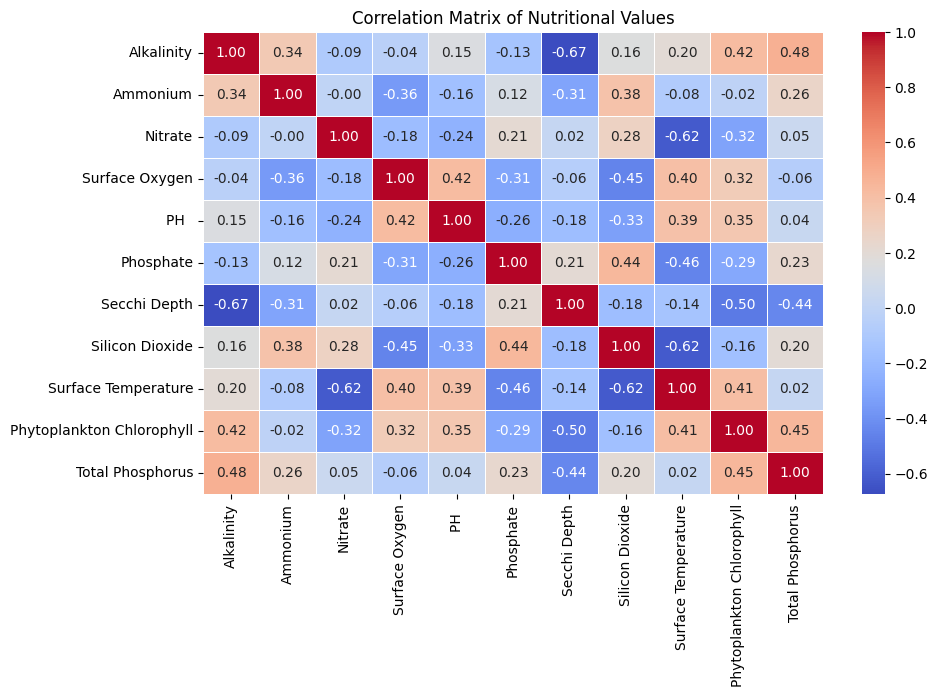

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.drop(columns=['Name', 'Date']).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Nutritional Values')
plt.show()


In [19]:
# Columns that need conversion from µg/L to mg/L, the rest PO4P, TOCA, TOTP are in µg/L.
columns_to_convert = ['Alkalinity', 'Ammonium', 'Nitrate', 'Silicon Dioxide']

# Convert each of these columns to mg/L
for column in columns_to_convert:
    df[column] = df[column] / 1000

df.head()

Name        Date  Alkalinity  Ammonium  Nitrate  Surface Oxygen  PH    \
0  Belham  08/01/1969        25.0     0.007     0.66            94.0   7.1   
1  Belham  14/01/1969        25.0     0.007     0.66            97.0   7.1   
2  Belham  21/01/1969        25.0     0.007     0.74            95.0   7.1   
3  Belham  28/01/1969        25.0     0.007     0.91            93.0   7.1   
4  Belham  04/02/1969        25.0     0.007     0.90            93.0   7.1   

   Phosphate  Secchi Depth  Silicon Dioxide  Surface Temperature  \
0       11.0           3.5             2.94                  3.0   
1       10.0           3.5             2.94                  3.0   
2       13.0           3.5             2.74                  4.0   
3       13.0           3.5             2.63                  5.0   
4       11.0           3.5             2.13                  3.4   

   Phytoplankton Chlorophyll  Total Phosphorus  
0                        1.0              64.0  
1                        1.0              64.0  
2                        1.4              64.0  
3                        1.1              64.0  
4                        1.4              64.0

In [21]:
# Convert OXYG from percentage to decimal
df['Surface Oxygen'] = df['Surface Oxygen'] / 100
df.head()

Name        Date  Alkalinity  Ammonium  Nitrate  Surface Oxygen  PH    \
0  Belham  08/01/1969        25.0     0.007     0.66            0.94   7.1   
1  Belham  14/01/1969        25.0     0.007     0.66            0.97   7.1   
2  Belham  21/01/1969        25.0     0.007     0.74            0.95   7.1   
3  Belham  28/01/1969        25.0     0.007     0.91            0.93   7.1   
4  Belham  04/02/1969        25.0     0.007     0.90            0.93   7.1   

   Phosphate  Secchi Depth  Silicon Dioxide  Surface Temperature  \
0       11.0           3.5             2.94                  3.0   
1       10.0           3.5             2.94                  3.0   
2       13.0           3.5             2.74                  4.0   
3       13.0           3.5             2.63                  5.0   
4       11.0           3.5             2.13                  3.4   

   Phytoplankton Chlorophyll  Total Phosphorus  
0                        1.0              64.0  
1                        1.0              64.0  
2                        1.4              64.0  
3                        1.1              64.0  
4                        1.4              64.0

In [23]:
# Convert 'Date' column to datetime, handling errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

This code calculates and plots the monthly mean trends of various nutrients for each lake, visualizing seasonal variations.


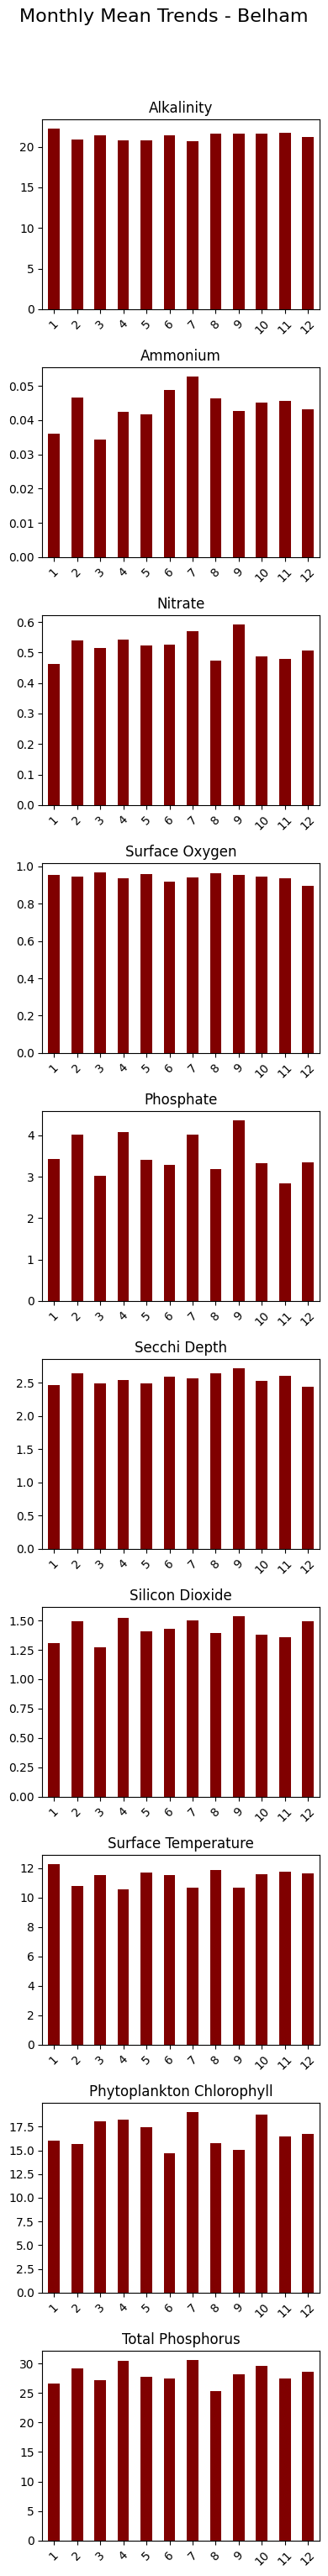

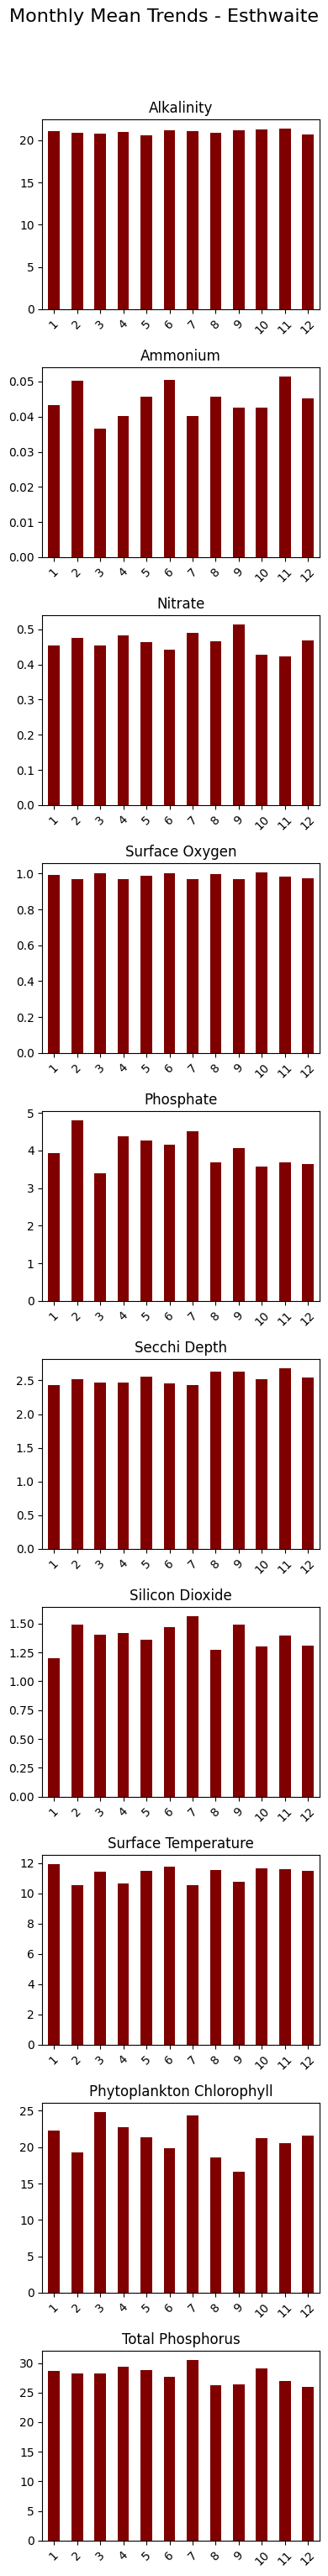

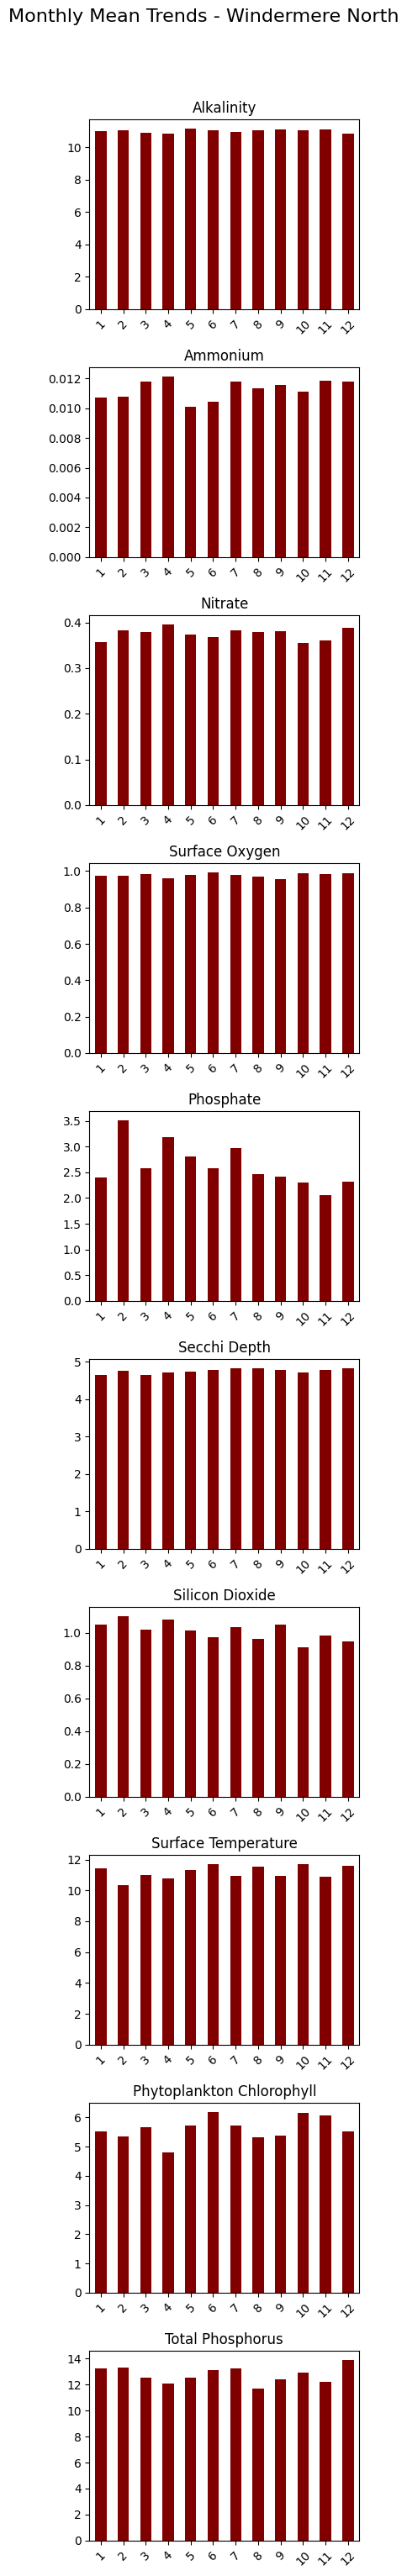

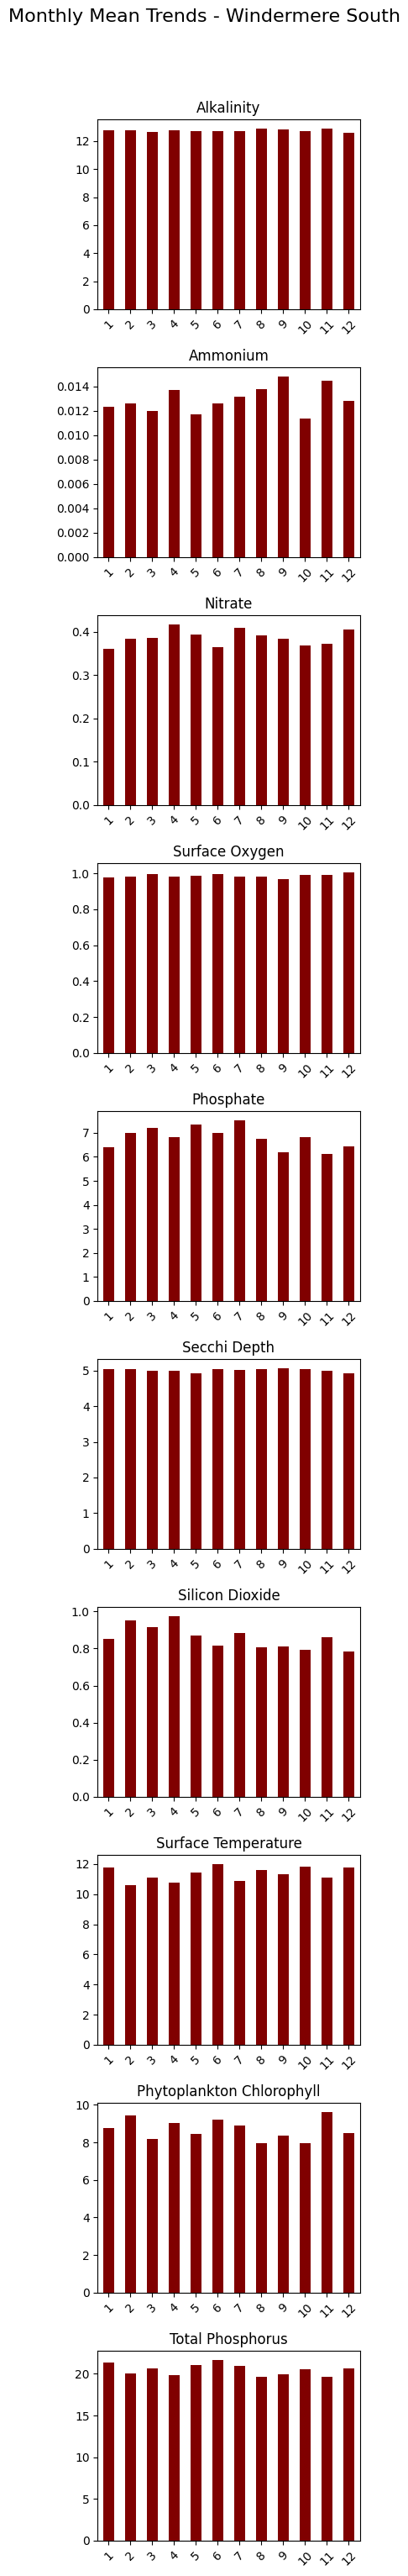

In [25]:
# Monthly mean average of nutrients of each Lake

df['Month'] = df['Date'].dt.month

# List of nutrients
nutrients = ['Alkalinity', 'Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Silicon Dioxide',
             'Surface Temperature',	'Phytoplankton Chlorophyll', 'Total Phosphorus']

# Loop over each unique lake
for lake in df['Name'].unique():
    lake_df = df[df['Name'] == lake]
    
    # Create subplots for nutrients
    fig, axes = plt.subplots(len(nutrients), 1, figsize=(4, 3 * len(nutrients)))
    fig.suptitle(f'Monthly Mean Trends - {lake}', fontsize=16, y=1.02)

    for i, nutrient in enumerate(nutrients):
        monthly_data = lake_df.groupby('Month')[nutrient].mean()
        monthly_data.plot(kind='bar', ax=axes[i], color='maroon')
        axes[i].set_title(f'{nutrient}')
        axes[i].set_xlabel('')
        axes[i].set_xticks(range(0, 12))
        axes[i].set_xticklabels(range(1, 13), rotation=45)

    plt.tight_layout()
    plt.show()


This code generates seasonal boxplots for each lake's nutrient distribution, highlighting seasonal trends with LOWESS smoothing for clearer trend visualization.


C:\Users\HP\AppData\Local\Temp\ipykernel_33816\1956911016.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_df['Season_num'] = lake_df['Season'].map(season_mapping)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is depre

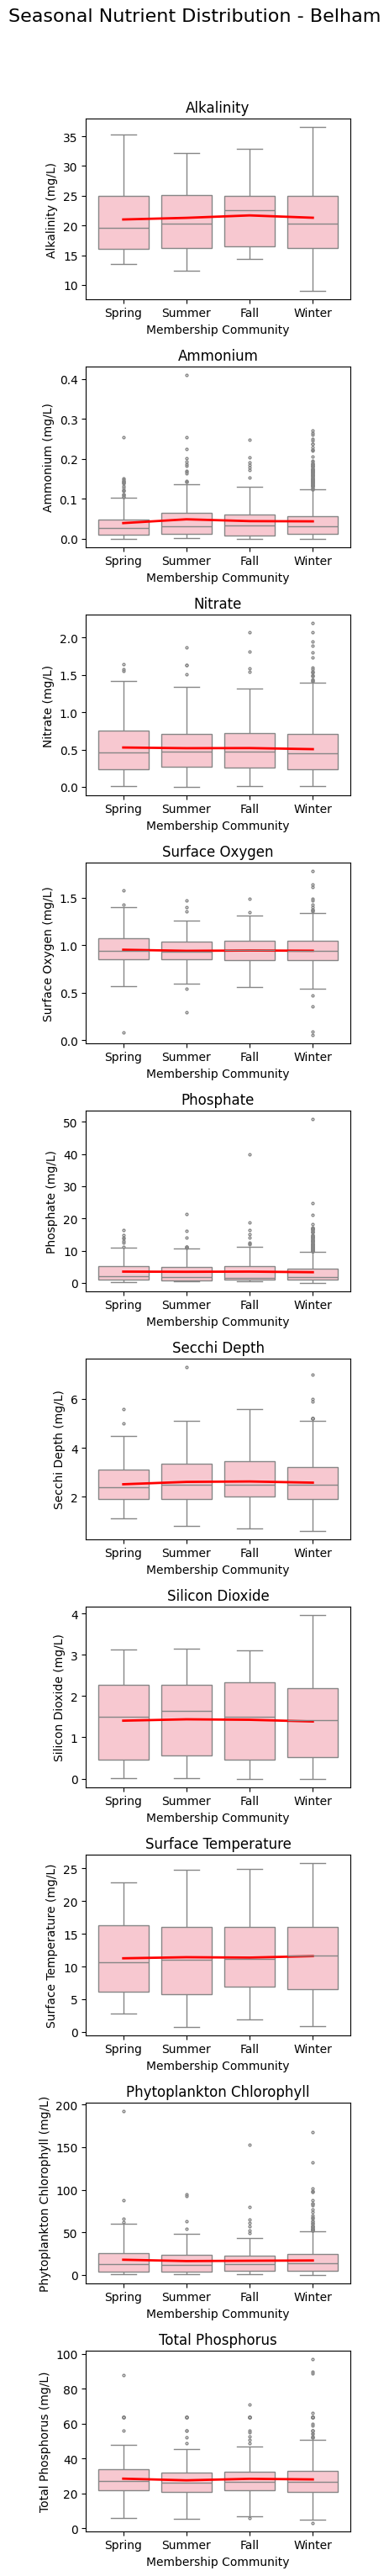

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\1956911016.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_df['Season_num'] = lake_df['Season'].map(season_mapping)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is depre

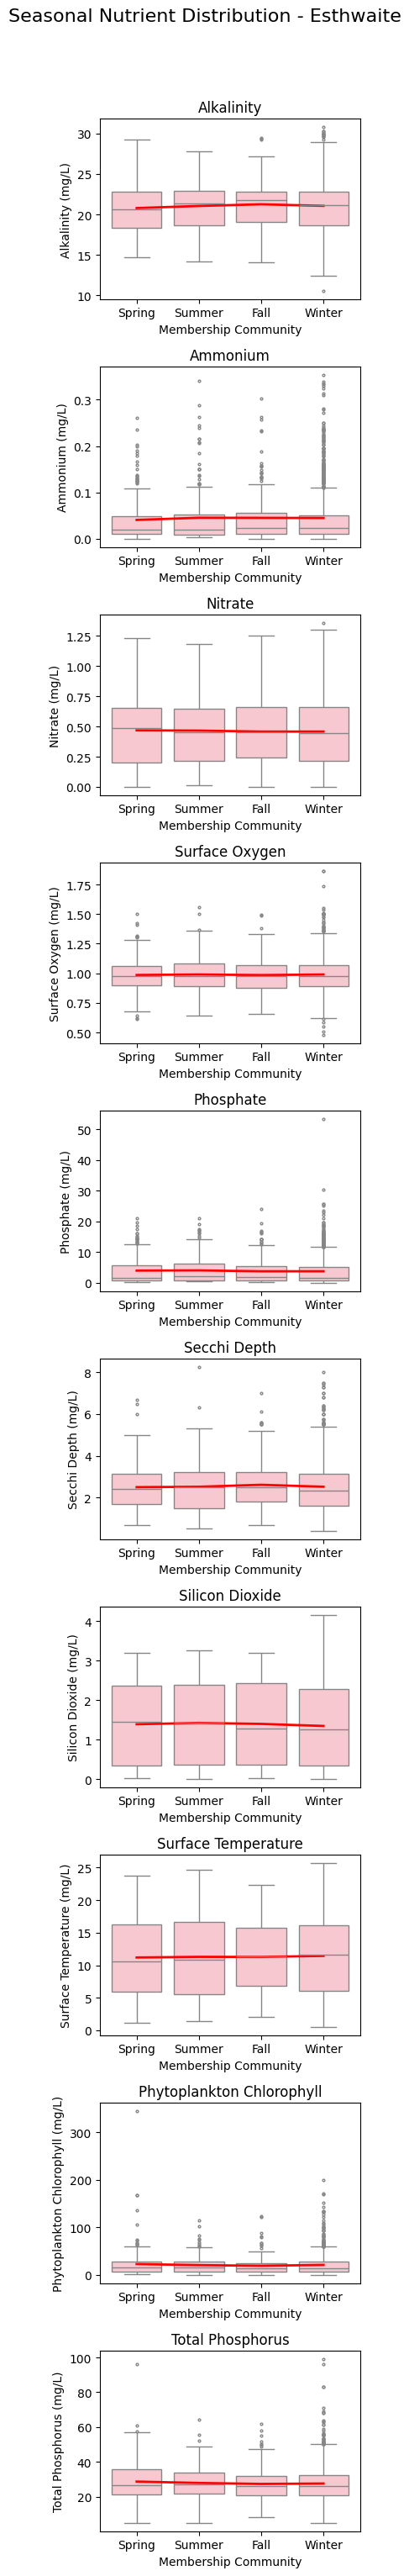

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\1956911016.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_df['Season_num'] = lake_df['Season'].map(season_mapping)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is depre

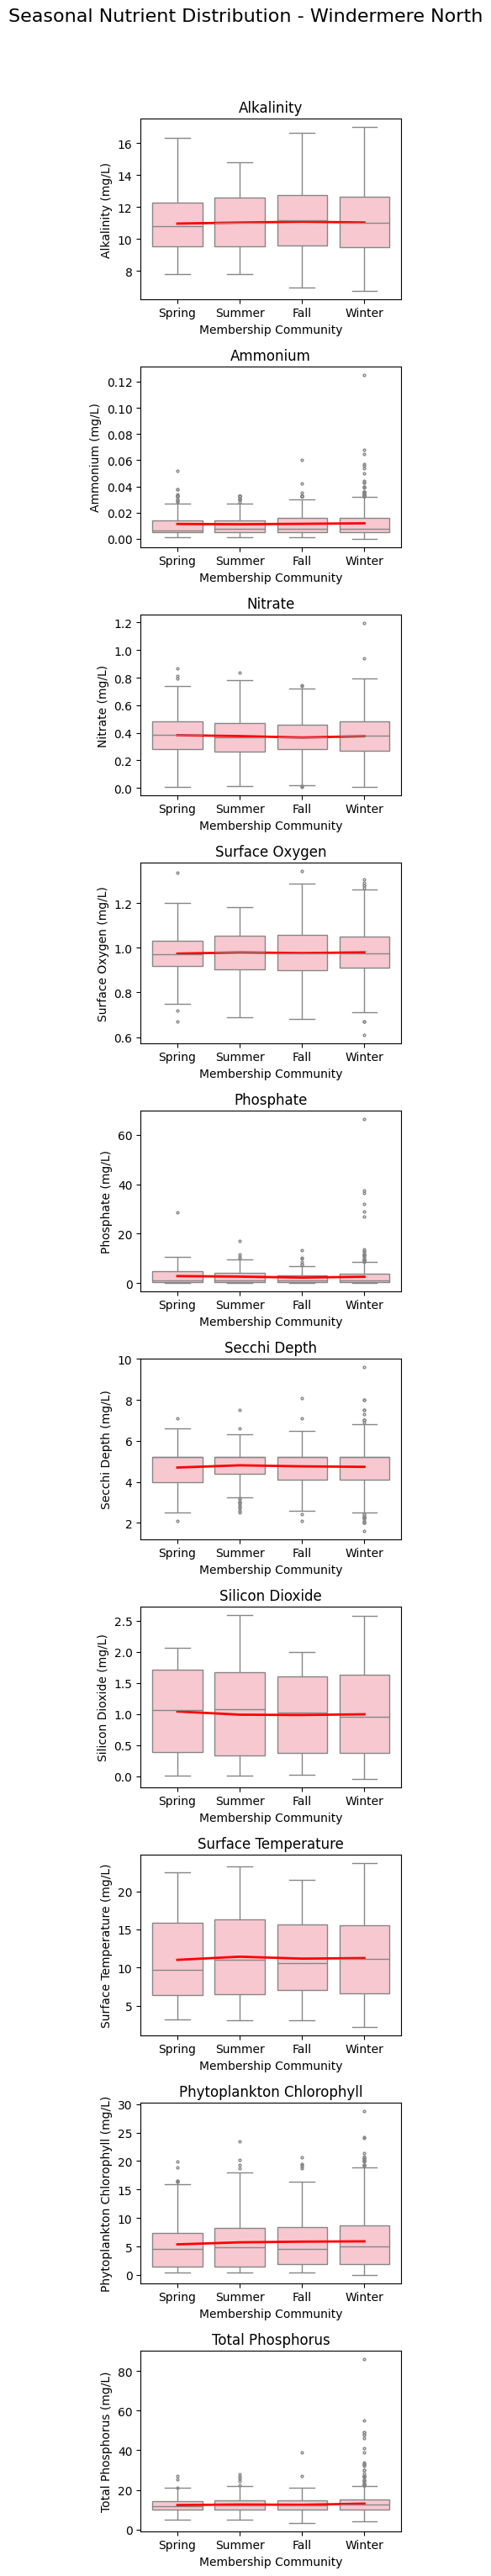

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\1956911016.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_df['Season_num'] = lake_df['Season'].map(season_mapping)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is depre

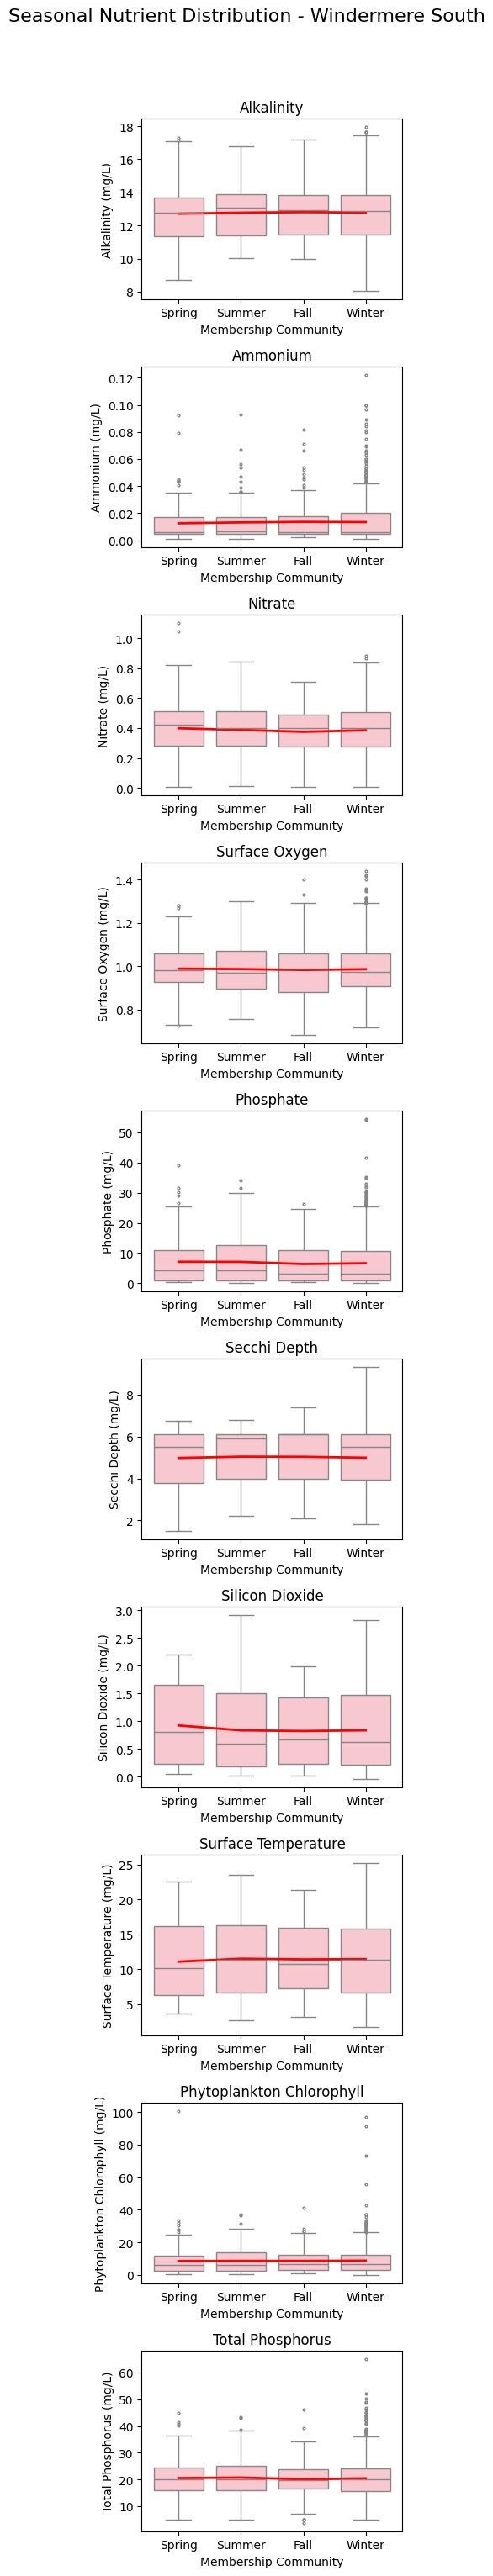

In [ ]:
# Seasonal Boxplots of nutrients of each Lake
# Extract Month and map to Season
df['Month'] = df['Date'].dt.month
def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'

df['Season'] = df['Month'].apply(get_season)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_mapping = {season: idx for idx, season in enumerate(season_order)}

nutrients = ['Alkalinity', 'Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Silicon Dioxide',
             'Surface Temperature',	'Phytoplankton Chlorophyll', 'Total Phosphorus']
flierprops = dict(marker='o', color='red', markersize=2, markeredgewidth=1)

# Loop over each lake
for lake in df['Name'].unique():
    lake_df = df[df['Name'] == lake]
    lake_df['Season_num'] = lake_df['Season'].map(season_mapping)

    fig, axes = plt.subplots(len(nutrients), 1, figsize=(4, 3 * len(nutrients)))
    fig.suptitle(f'Seasonal Nutrient Distribution - {lake}', fontsize=16, y=1.02)

    for i, nutrient in enumerate(nutrients):
        # Boxplot
        sns.boxplot(x='Season', y=nutrient, data=lake_df, ax=axes[i],
                    color='pink', order=season_order,
                    showfliers=True, flierprops=flierprops, whis=1.5)

        # LOWESS line
        season_avg = lake_df.groupby('Season')[[nutrient]].mean().reset_index()
        season_avg['Season_num'] = season_avg['Season'].map(season_mapping)
        lowess_result = lowess(season_avg[nutrient], season_avg['Season_num'], frac=0.9)
        axes[i].plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=2, label='LOWESS')

        # Labels
        axes[i].set_title(f'{nutrient}')
        axes[i].set_xlabel('Membership Community')
        axes[i].set_ylabel(f'{nutrient} (mg/L)')


    plt.tight_layout()
    plt.show()


This code visualizes the yearly nutrient trends for each lake, using LOWESS smoothing to highlight underlying patterns in the data.


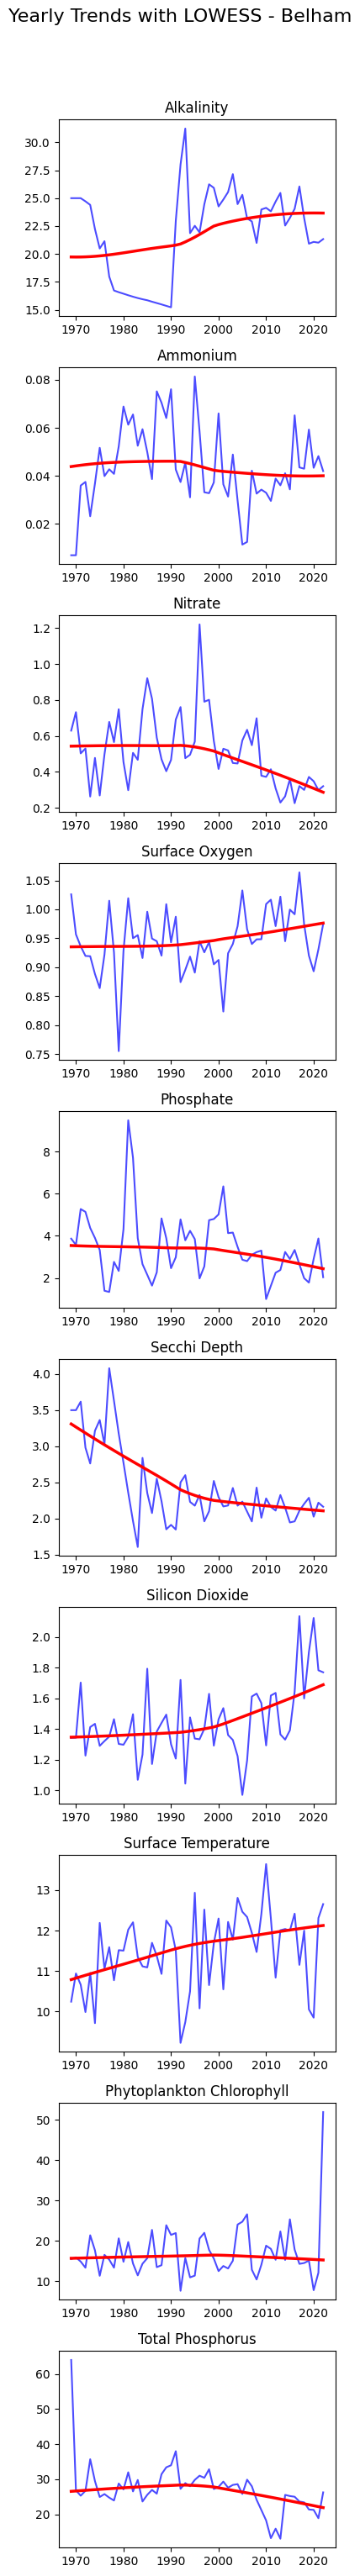

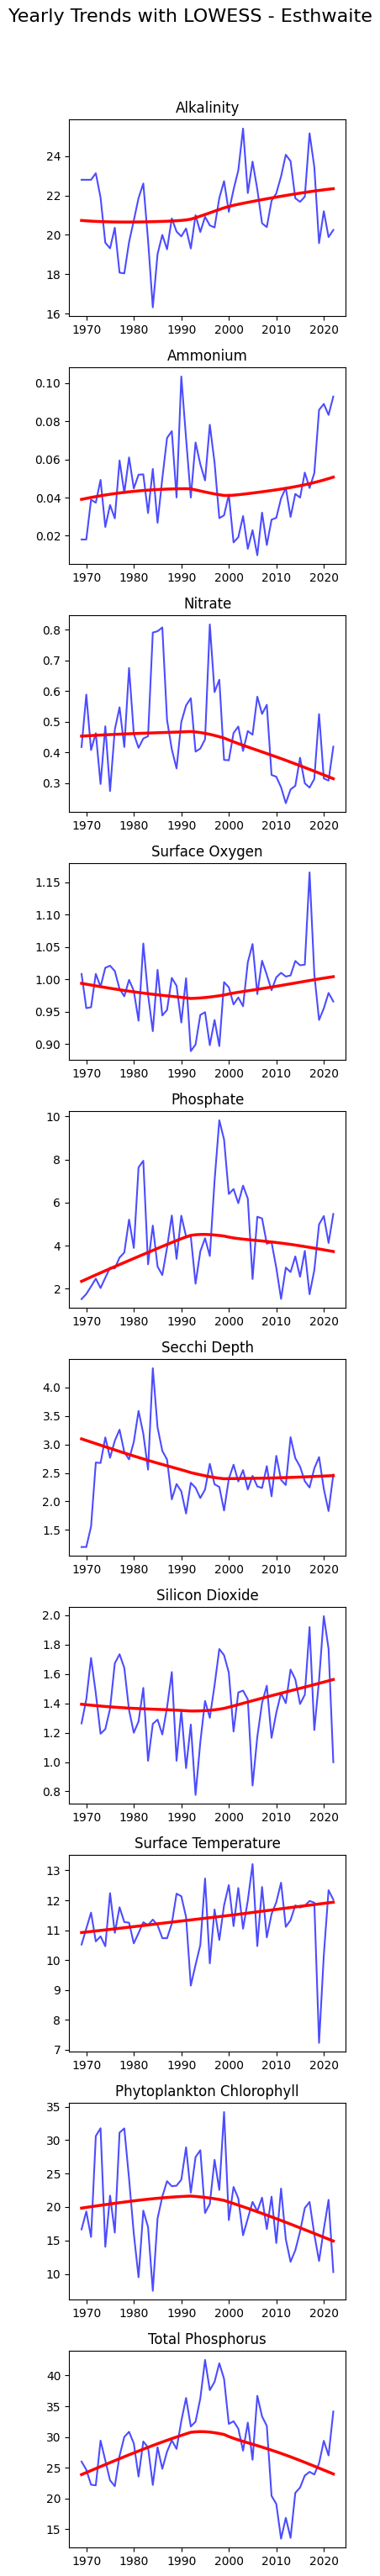

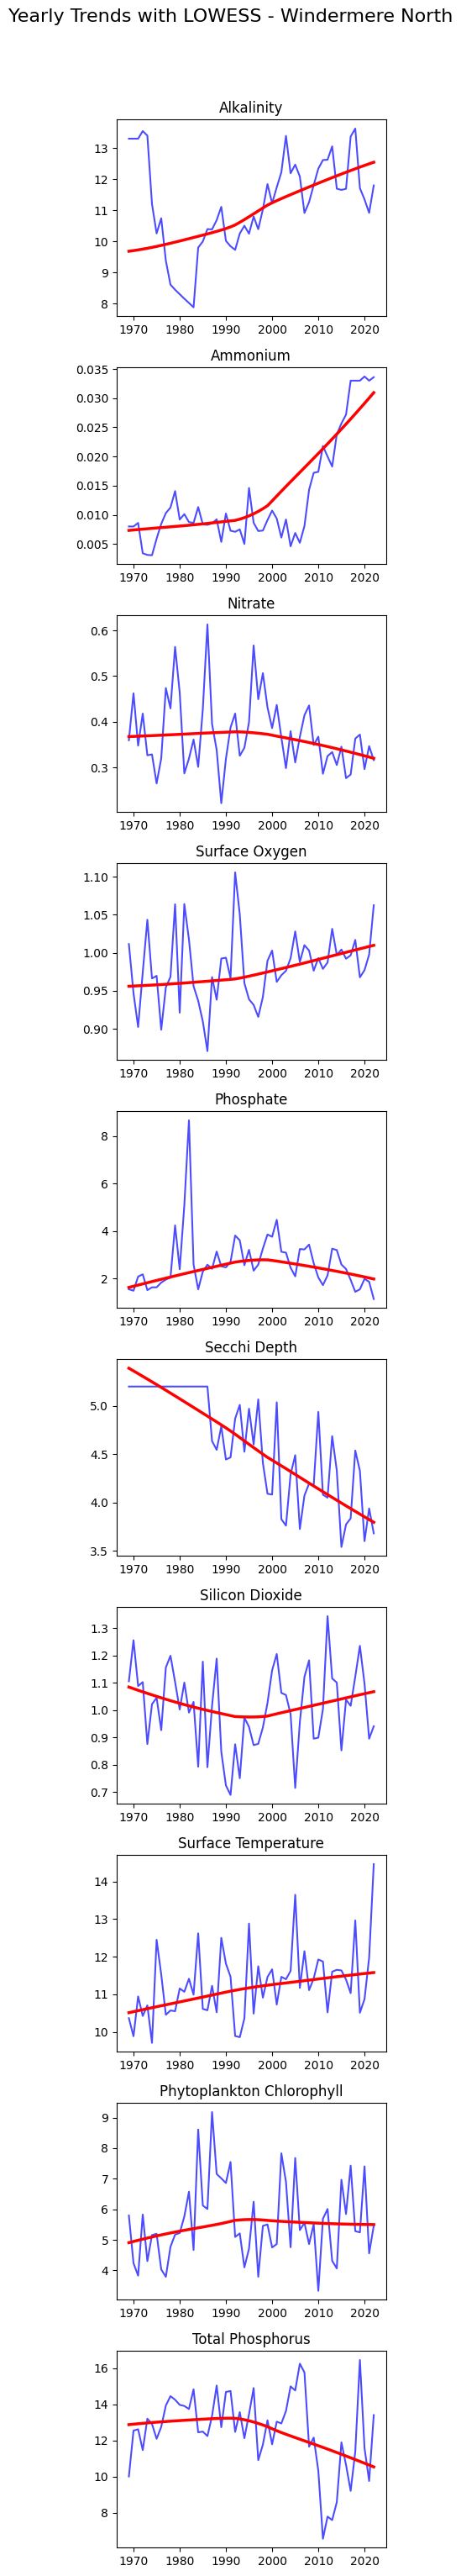

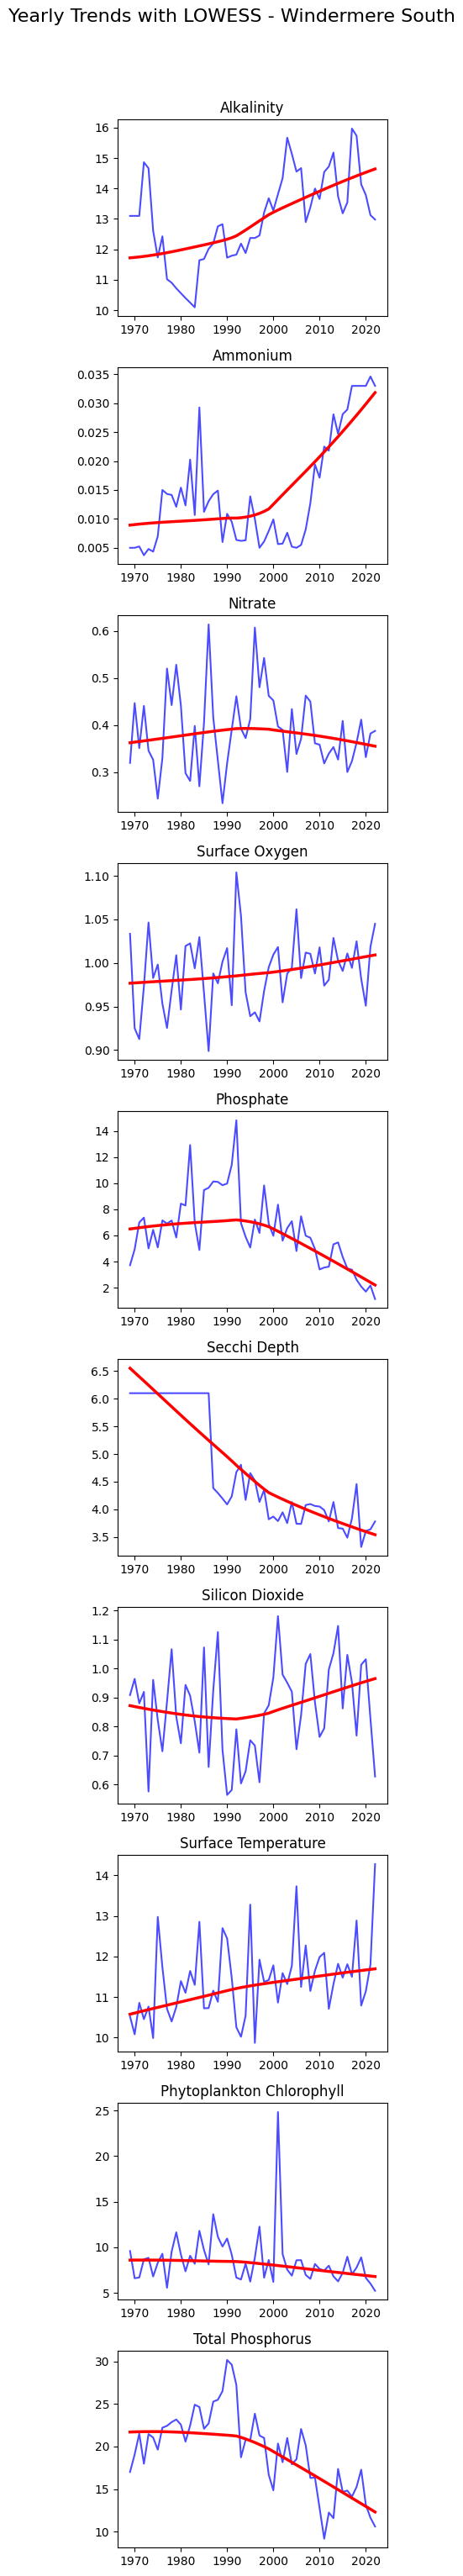

In [29]:
# Yearly distribution trend for nutrients for each Lake

# Extract Year
df['Year'] = df['Date'].dt.year
nutrients = ['Alkalinity', 'Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Silicon Dioxide',
             'Surface Temperature',	'Phytoplankton Chlorophyll', 'Total Phosphorus']

# Loop over lakes
for lake in df['Name'].unique():
    lake_df = df[df['Name'] == lake]

    fig, axes = plt.subplots(len(nutrients), 1, figsize=(4, 3 * len(nutrients)))
    fig.suptitle(f'Yearly Trends with LOWESS - {lake}', fontsize=16, y=1.02)

    for i, nutrient in enumerate(nutrients):
        yearly_data = lake_df.groupby('Year')[nutrient].mean().dropna()
        years = yearly_data.index
        values = yearly_data.values

        smoothed = lowess(values, years, frac=0.9)

        axes[i].plot(years, values, 'b-', label='Actual', alpha=0.7)
        axes[i].plot(smoothed[:, 0], smoothed[:, 1], 'r-', label='LOWESS', linewidth=2.5)
        axes[i].set_title(f'{nutrient}')



    plt.tight_layout()
    plt.show()


This code generates boxplots to compare the distribution of each nutrient across different lakes, highlighting variations and potential outliers.


C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


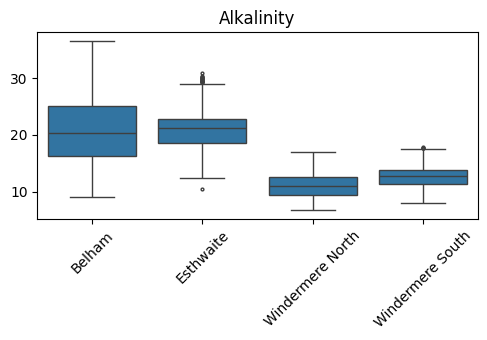

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


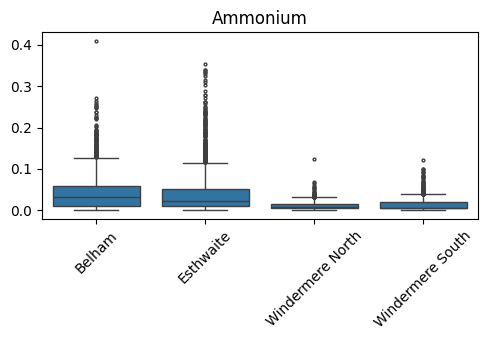

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


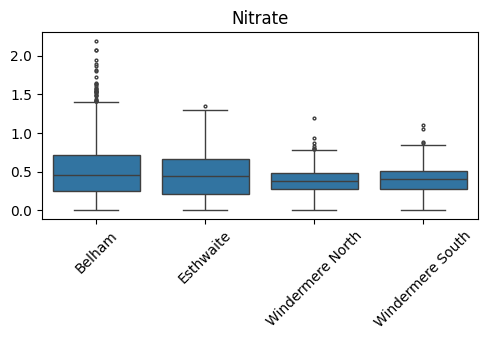

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


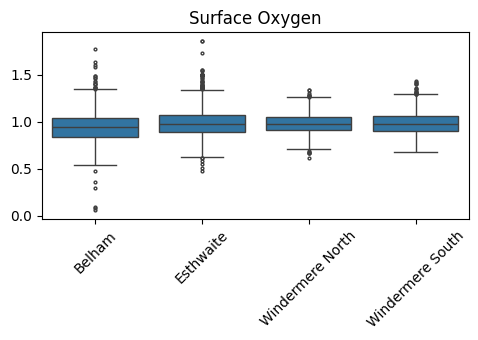

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


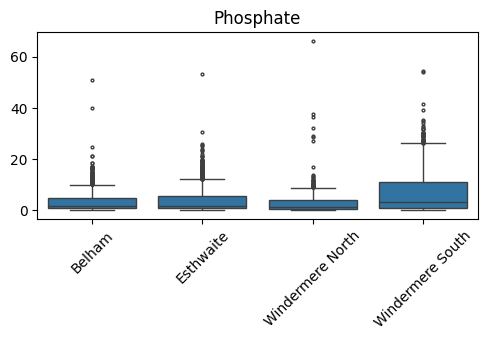

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


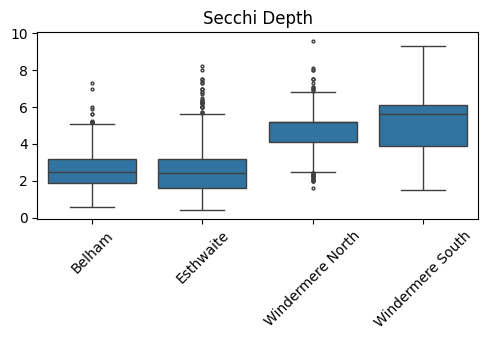

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


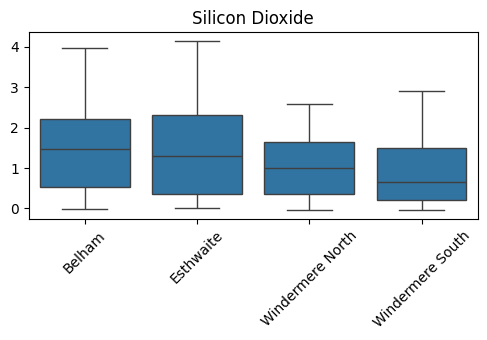

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


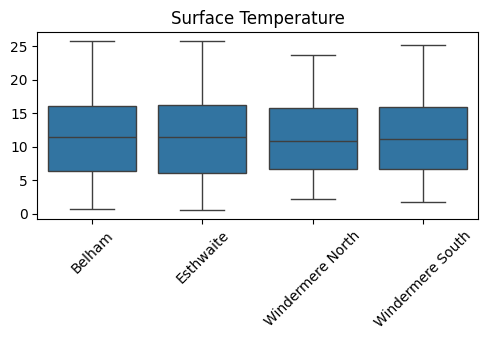

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


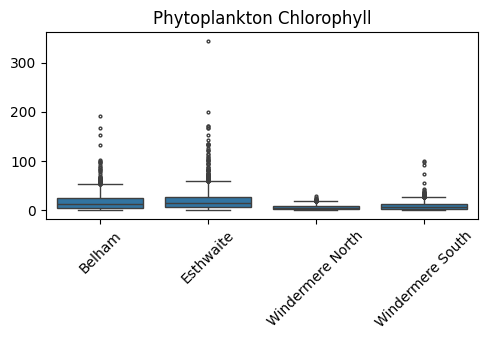

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


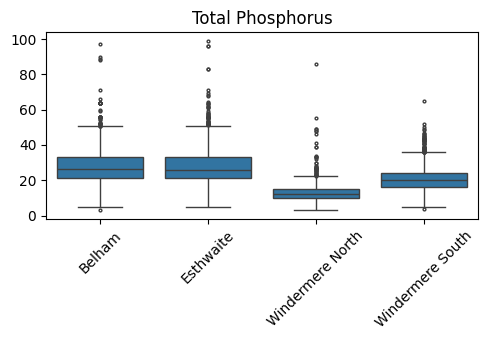

In [55]:
# Compare Between Lakes (Boxplot for Each Nutrient)

nutrients = ['Alkalinity', 'Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Silicon Dioxide',
             'Surface Temperature',	'Phytoplankton Chlorophyll', 'Total Phosphorus']
flierprops = dict(marker='o', color='red', markersize=2, markeredgewidth=1)

for nutrient in nutrients:
    plt.figure(figsize=(5, 3.5))
    sns.boxplot(x='Name', y=nutrient, data=df,showfliers=True, flierprops=flierprops, whis=1.5)
    plt.title(f'{nutrient}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


This code classifies lakes based on their Total Phosphorus (TOTP) levels into three categories: **Oligotrophic** (low nutrients), **Mesotrophic** (moderate nutrients), and **Eutrophic** (high nutrients). It visualizes the classification using a countplot to show the distribution of lakes by trophic status and associated bloom risks.


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


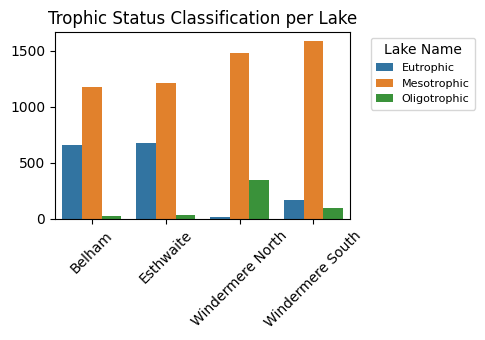

In [ ]:
# Trophic Status Classification
  
# Define trophic state based on TOTP
def classify_trophic_state(totp):
    if totp < 10:
        return 'Oligotrophic'
    elif totp < 30:
        return 'Mesotrophic'
    else:
        return 'Eutrophic'

# Apply classification
df['Trophic_Status'] = df['Total Phosphorus'].apply(classify_trophic_state)

# Countplot per Lake with legend outside
plt.figure(figsize=(5, 3.5))
sns.countplot(data=df, x='Name', hue='Trophic_Status')
plt.title("Trophic Status Classification per Lake")
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')

# Place legend outside
# Adjust legend box size and font size, keeping the legend box visible
plt.legend(
    title='Lake Name', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=8,             # Reduce font size of legend labels
    title_fontsize=10,      # Reduce font size of legend title
    borderpad=0.5,          # Reduce padding inside the legend box
    labelspacing=0.5,       # Reduce space between labels
    handlelength=1.5,       # Adjust line length in legend
    frameon=True,           # Ensure the frame (box) is present around the legend
    borderaxespad=0.5      # Reduce the padding between the legend box and plot
)


plt.tight_layout()
plt.show()



This analysis explores the relationship between **Surface Temperature** and various nutrient levels across different lakes. It uses linear regression plots to visualize how temperature correlates with each nutrient over time, with separate plots for each lake.


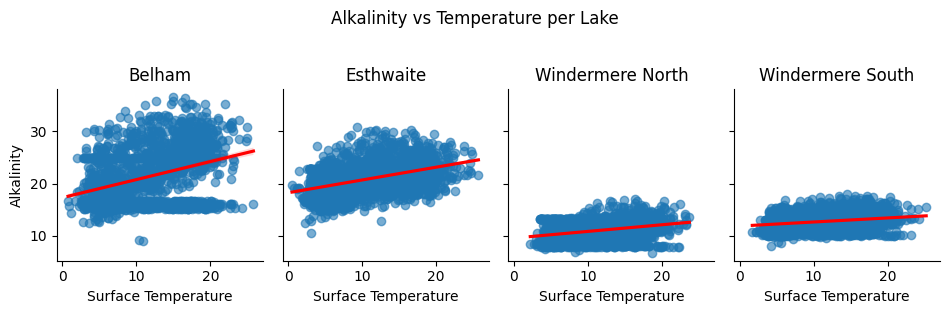

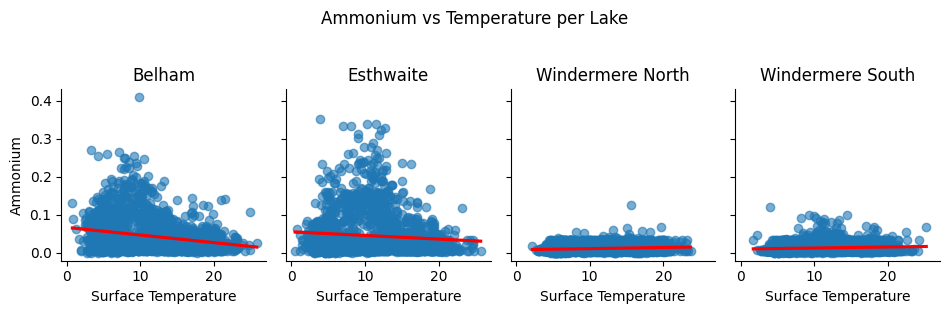

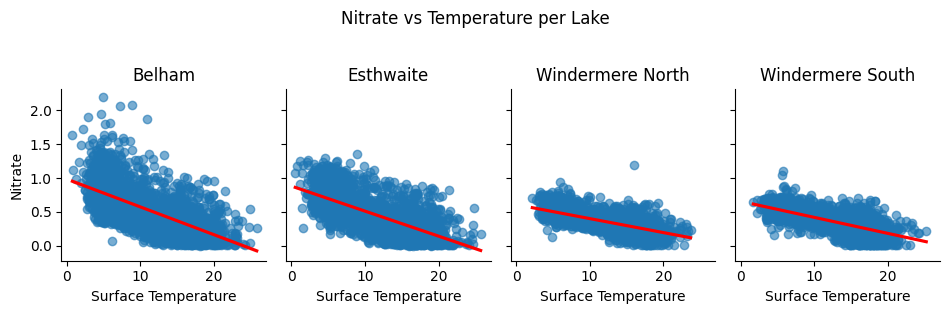

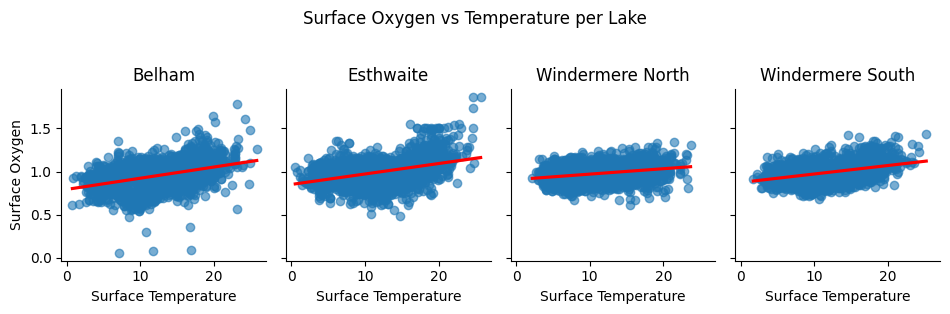

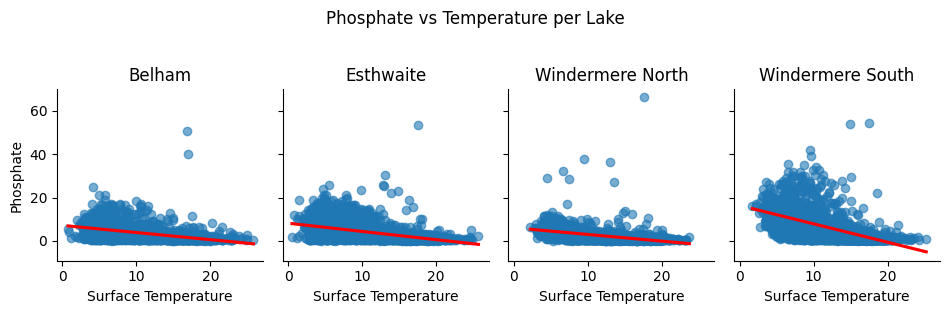

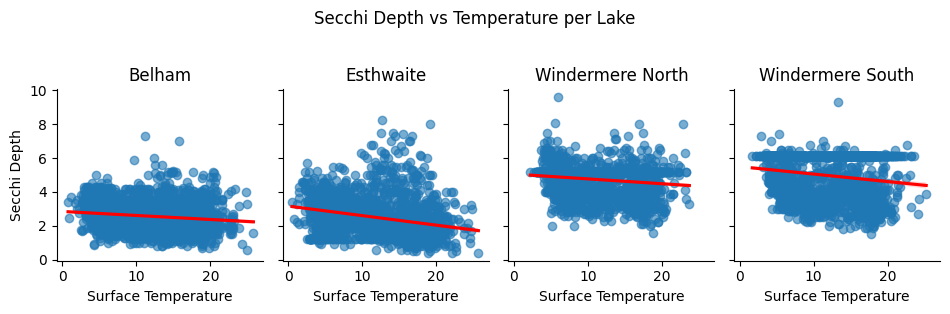

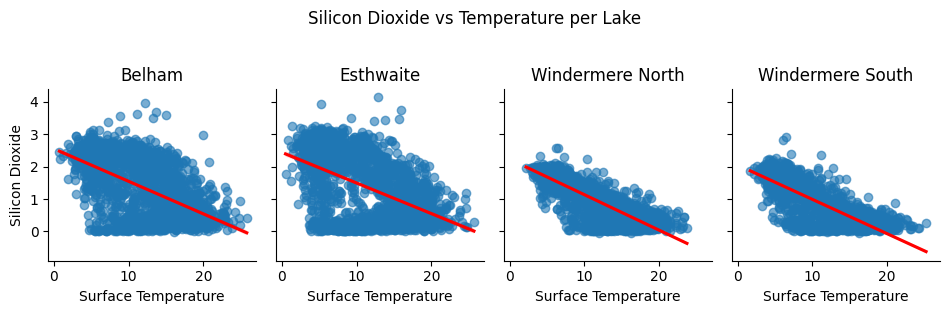

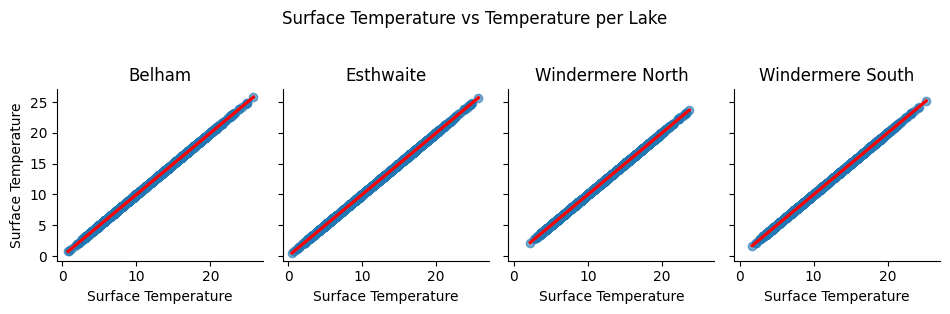

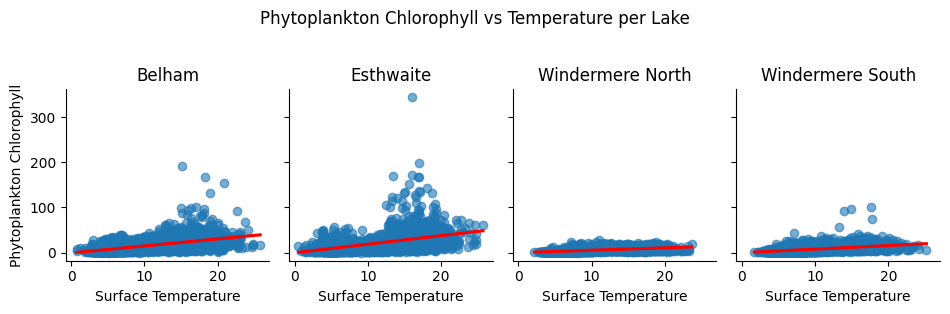

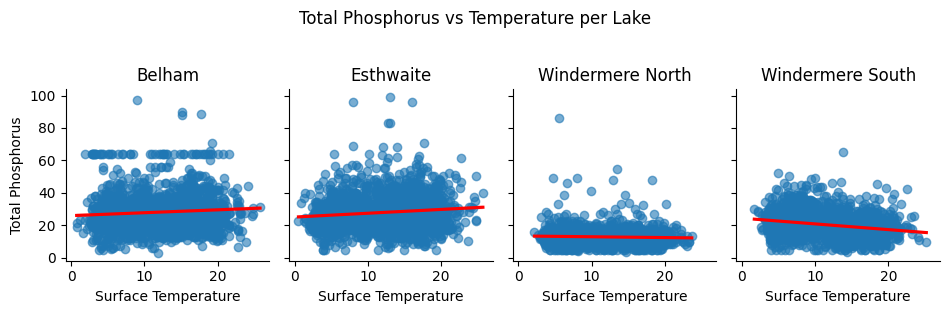

In [70]:
# Climate-Related Analysis: TEMP vs Nutrients & Time

nutrients = ['Alkalinity', 'Ammonium', 'Nitrate', 'Surface Oxygen', 'Phosphate', 'Secchi Depth', 'Silicon Dioxide',
             'Surface Temperature',	'Phytoplankton Chlorophyll', 'Total Phosphorus']

for nutrient in nutrients:
    g = sns.lmplot(
        data=df, x='Surface Temperature', y=nutrient, col='Name',
        height=3, aspect=0.8, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}
    )

    # Clean the facet titles to only show the lake name
    for ax in g.axes.flatten():
        title_text = ax.get_title().replace('Name = ', '')
        ax.set_title(title_text)

    g.fig.suptitle(f"{nutrient} vs Temperature per Lake", y=1.03)
    plt.tight_layout()
    plt.show()


The Phytoplankton dataset contains 53,475 entries of phytoplankton observations across multiple Cumbrian lakes (Belham, Esthwaite, Windermere South Basin, and Windermere North Basin), spanning from 1980 to 2005. It includes details on the taxon, value, form, and category of the phytoplankton, along with the date, month, and year of observation, helping to track phytoplankton dynamics over time. The categories consist of different types of algae, including Diatoms, Green Algae, and others. The exploratory data analysis (EDA) includes seasonal and yearly trends for these categories across the lakes, highlighting log-transformed values for improved boxplot scaling, smoothing trends using LOWESS, and visualizing seasonal distributions. Additionally, stacked area charts are used to observe the relative contributions of each phytoplankton category by year (1980-2005), providing insights into the temporal variations in nutrient levels and their impact on phytoplankton communities.


In [344]:
# Load the dataset
df = pd.read_csv("Cleaned_Phytoplankton_Data.csv")
df.head()

Date  Month  Year    Name Taxon  Value  Form Category
0  1978-01-03      1  1978  Belham  ASTF  25.30  CELL  Diatoms
1  1978-01-10      1  1978  Belham  ASTF  21.10  CELL  Diatoms
2  1978-01-17      1  1978  Belham  ASTF  26.30  CELL  Diatoms
3  1978-01-24      1  1978  Belham  ASTF  23.45  CELL  Diatoms
4  1978-02-07      2  1978  Belham  ASTF  23.55  CELL  Diatoms

In [346]:
df.shape

(53475, 8)

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53475 entries, 0 to 53474
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      53475 non-null  object 
 1   Month     53475 non-null  int64  
 2   Year      53475 non-null  int64  
 3   Name      53475 non-null  object 
 4   Taxon     53475 non-null  object 
 5   Value     53475 non-null  float64
 6   Form      53475 non-null  object 
 7   Category  53475 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.3+ MB


In [350]:
df.describe()

Month          Year         Value
count  53475.000000  53475.000000  53475.000000
mean       6.514278   1989.037644    117.174543
std        3.165256      7.351064    748.772656
min        1.000000   1978.000000      0.000000
25%        4.000000   1983.000000      0.000000
50%        7.000000   1988.000000      0.500000
75%        9.000000   1995.000000     17.000000
max       12.000000   2005.000000  74753.000000

In [352]:
df.isnull().sum()

Date        0
Month       0
Year        0
Name        0
Taxon       0
Value       0
Form        0
Category    0
dtype: int64

This code calculates the monthly mean of phytoplankton values by site and category, and then visualizes the trends with bar plots for each category at each site.


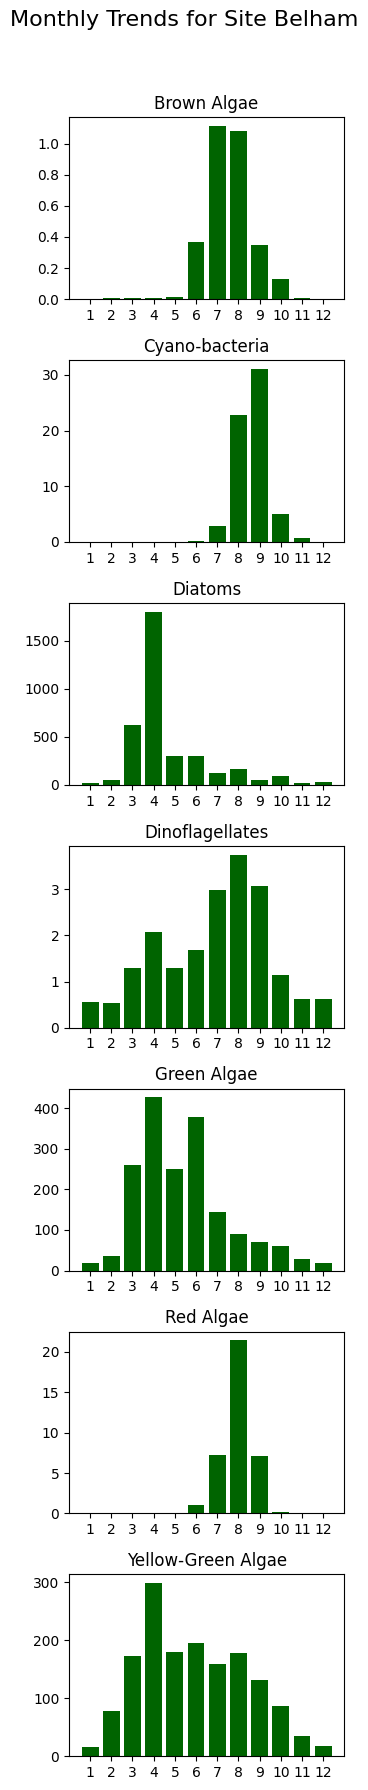

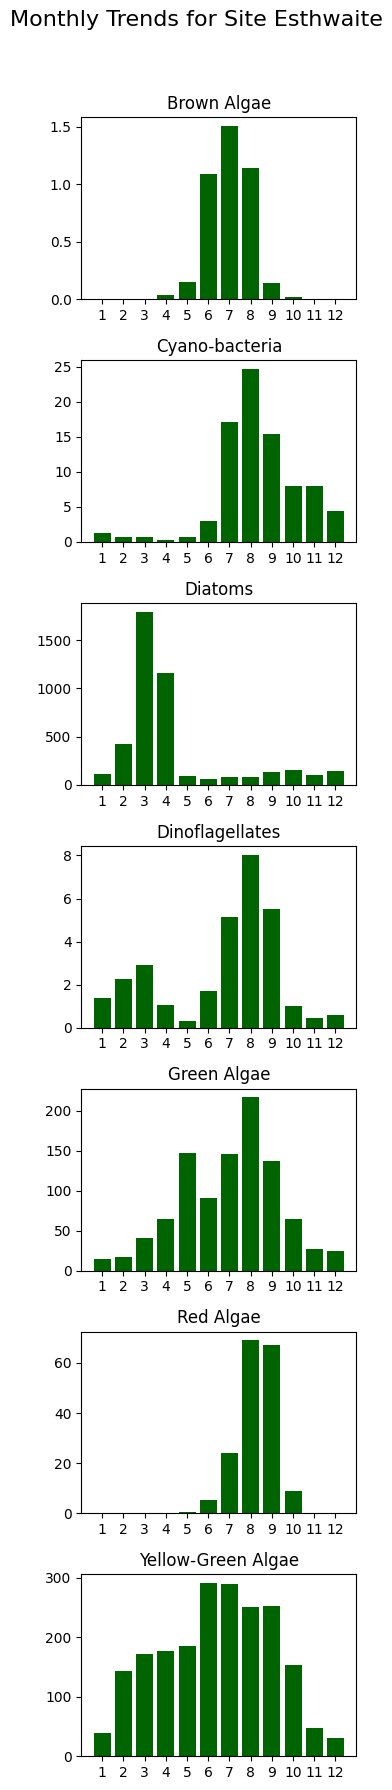

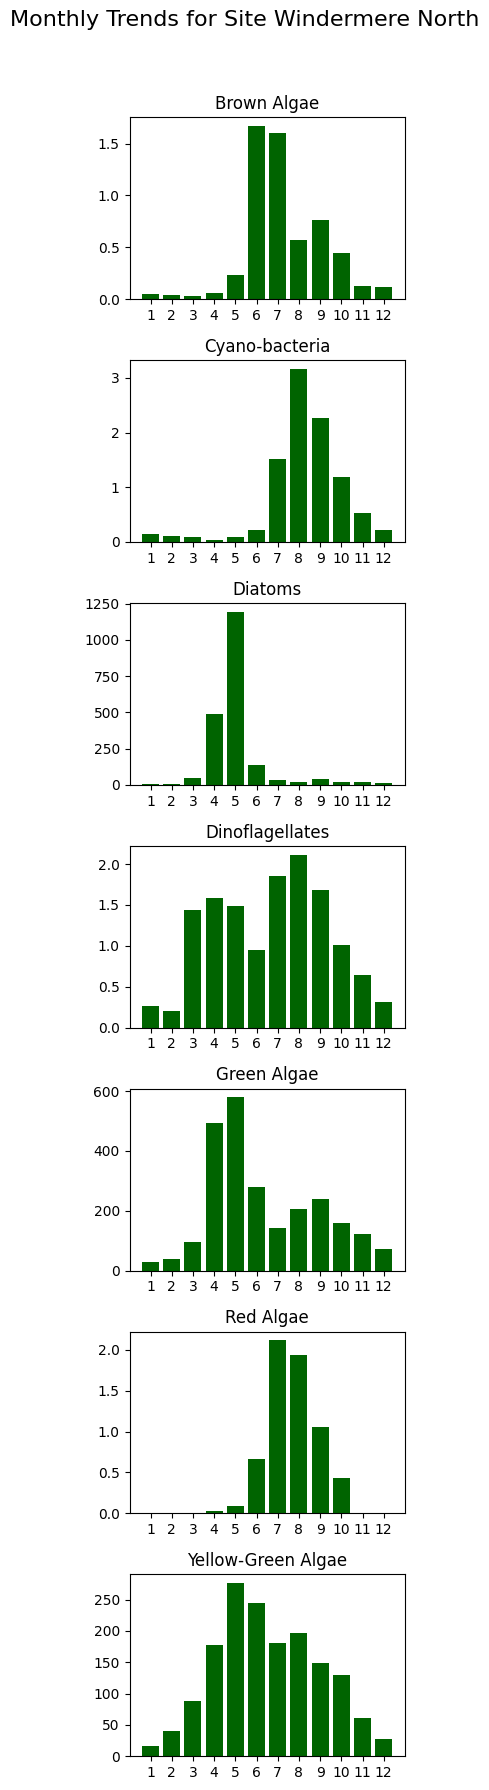

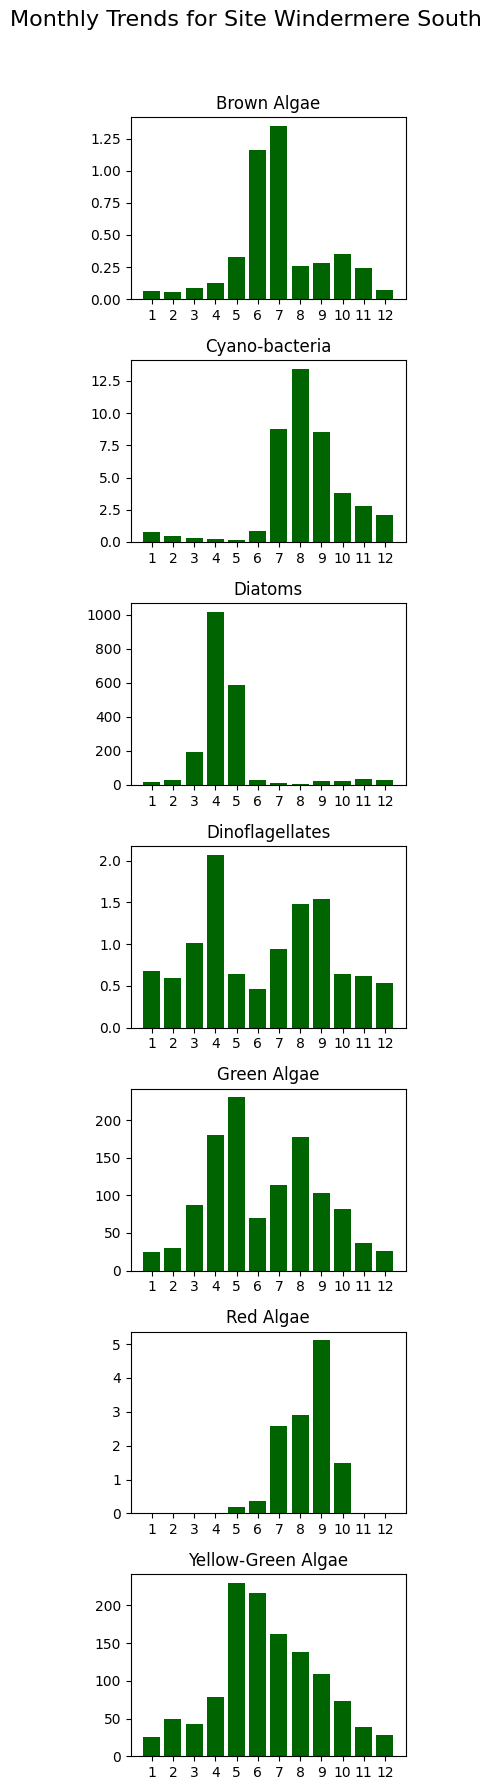

In [356]:
# Convert the 'date' column to datetime if it's not already
# Convert the 'Date' column to datetime without forcing a format
df['Date'] = pd.to_datetime(df['Date'])


# Group by 'name', 'category', and 'month' and calculate the mean for each group
monthly_mean = df.groupby(['Name', 'Category', 'Month'])['Value'].mean().reset_index()

# Get unique sites and categories
sites = monthly_mean['Name'].unique()
categories = monthly_mean['Category'].unique()

# Plot separate graphs for each category at each site
for site in sites:
    # Filter data for the current site
    site_data = monthly_mean[monthly_mean['Name'] == site]
    
    # Create a subplot for each category
    fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(3.5, 2.5 * len(categories)))

    # Title for the site
    fig.suptitle(f'Monthly Trends for Site {site}', fontsize=16, y=1.02)
    
    # Iterate through each category and plot
    for i, category in enumerate(categories):
        # Filter data for the current category
        category_data = site_data[site_data['Category'] == category]
        
        # Plot the bar graph
        axes[i].bar(category_data['Month'], category_data['Value'], color='darkgreen')
        axes[i].set_title(f'{category}', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_xticks(range(1, 13))  # Assuming months are from 1 to 12
        axes[i].set_xticklabels([f'{i}' for i in range(1, 13)])
    
    # Adjust the layout for better visibility
    plt.tight_layout()
    plt.show()


This code calculates the yearly mean of phytoplankton values by site and category, applies LOWESS smoothing to the data, and visualizes the trends for each category at each site over the years.


C:\Users\HP\AppData\Local\Temp\ipykernel_33816\261583002.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[i].plot(years, values, 'b-', color='darkgreen', alpha=0.7)


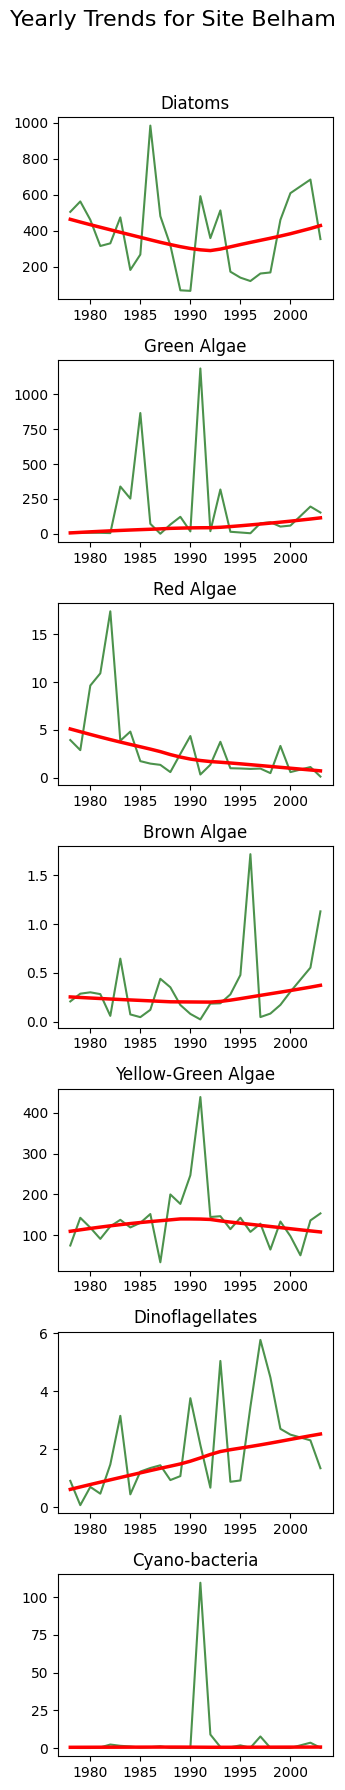

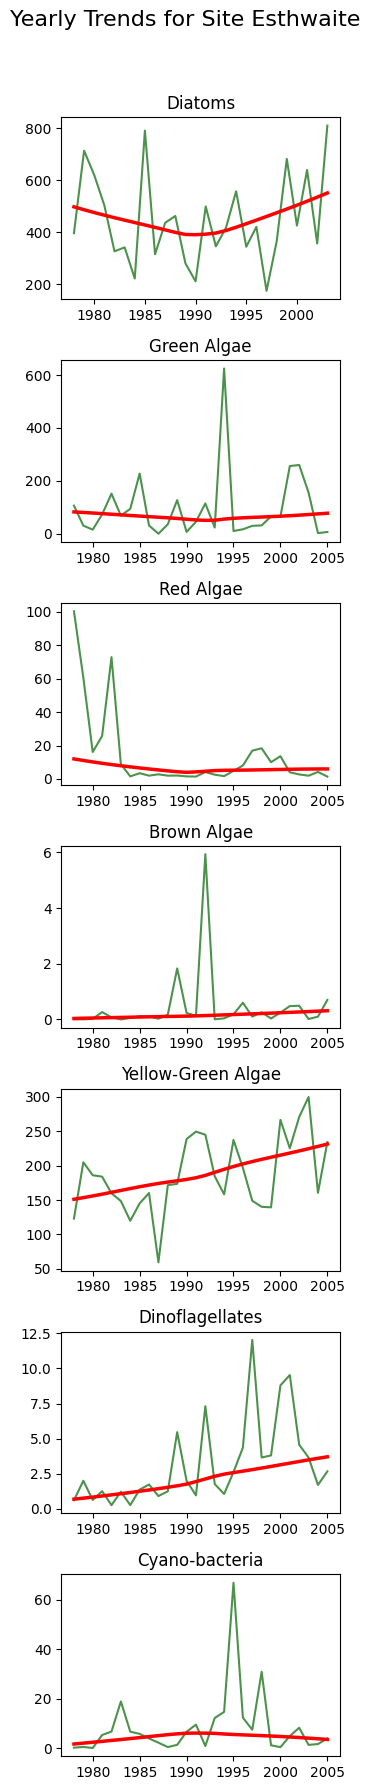

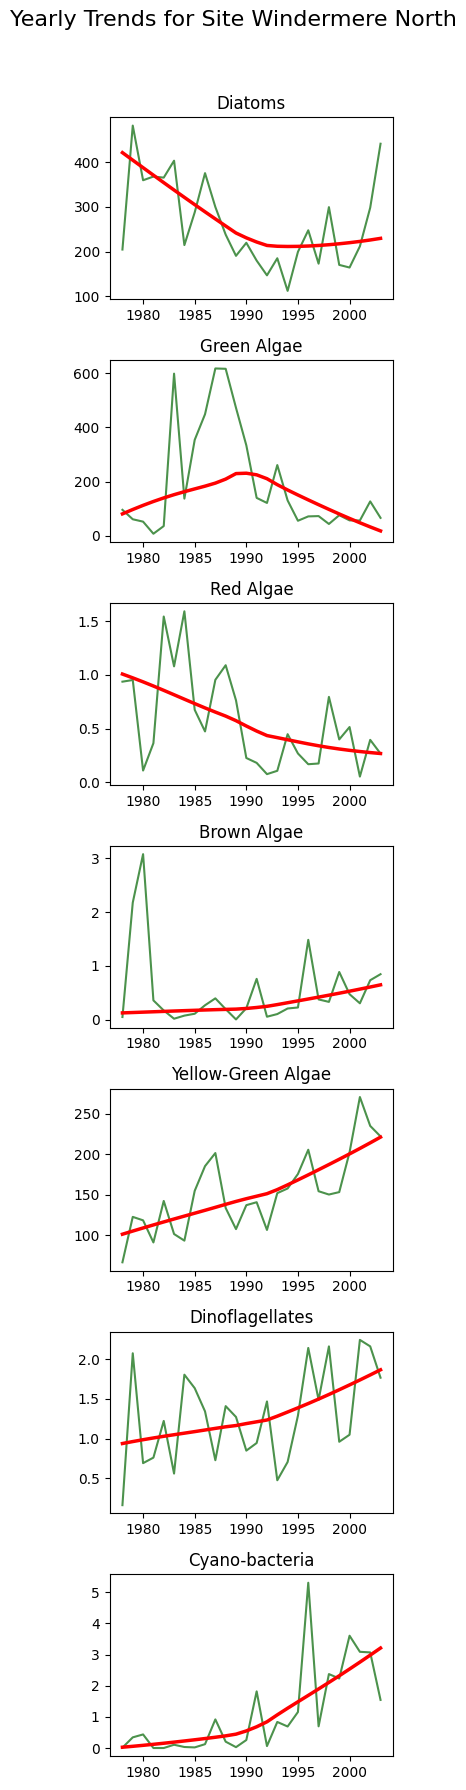

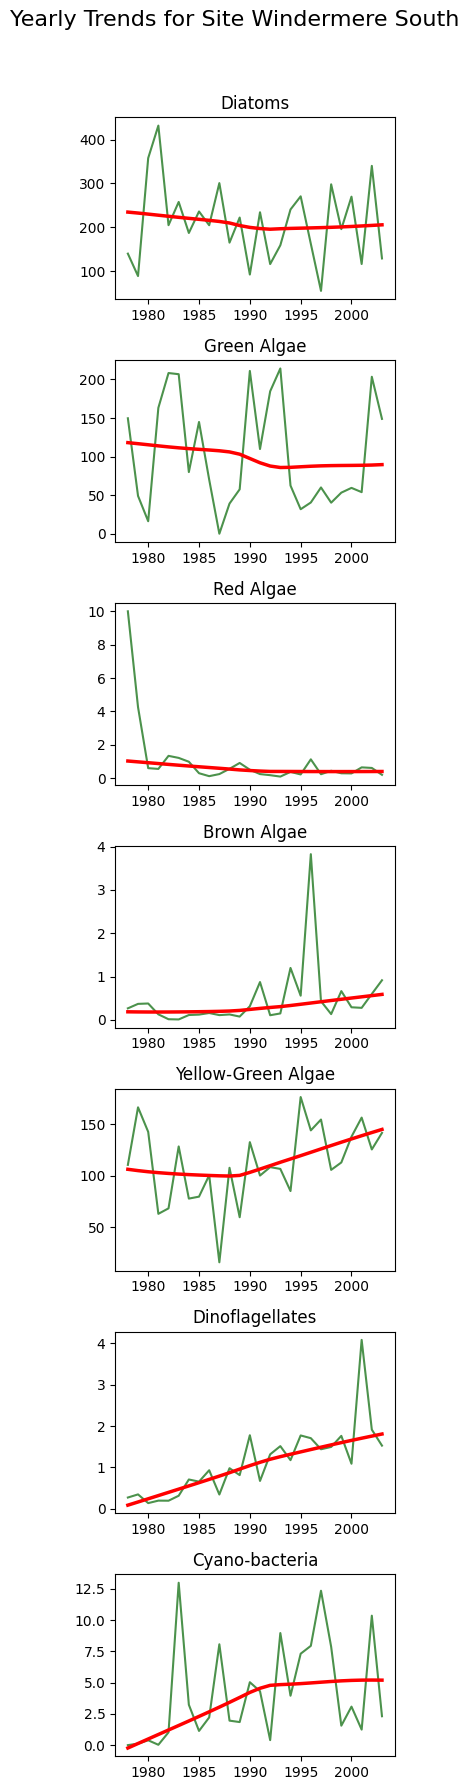

In [357]:

# Extract Year
df['Year'] = df['Date'].dt.year

# Get unique sites and categories
sites = df['Name'].unique()
categories = df['Category'].unique()

# Loop over sites
for site in sites:
    site_df = df[df['Name'] == site]

    # Create a subplot for each category with figure size adjusted
    fig, axes = plt.subplots(len(categories), 1, figsize=(3.5, 2.5 * len(categories)))
    fig.suptitle(f'Yearly Trends for Site {site}', fontsize=16, y=1.02)

    # Loop over each category
    for i, category in enumerate(categories):
        category_data = site_df[site_df['Category'] == category]
        
        # Group by Year and calculate the mean for each category per year
        yearly_data = category_data.groupby('Year')['Value'].mean().dropna()
        years = yearly_data.index
        values = yearly_data.values

        # Apply LOWESS for smoothing
        smoothed = lowess(values, years, frac=0.9)

        # Plot actual and smoothed data
        axes[i].plot(years, values, 'b-', color='darkgreen', alpha=0.7)
        axes[i].plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2.5)
        axes[i].set_title(f'{category}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Adjust the layout for better visibility
    plt.tight_layout()
    plt.show()


This code creates seasonal box plots for each algae category at each site, applying log transformation for scaling, displaying outliers, and overlaying a LOWESS smoothed trend to analyze the seasonal distribution and trends of algae across different seasons.


C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.

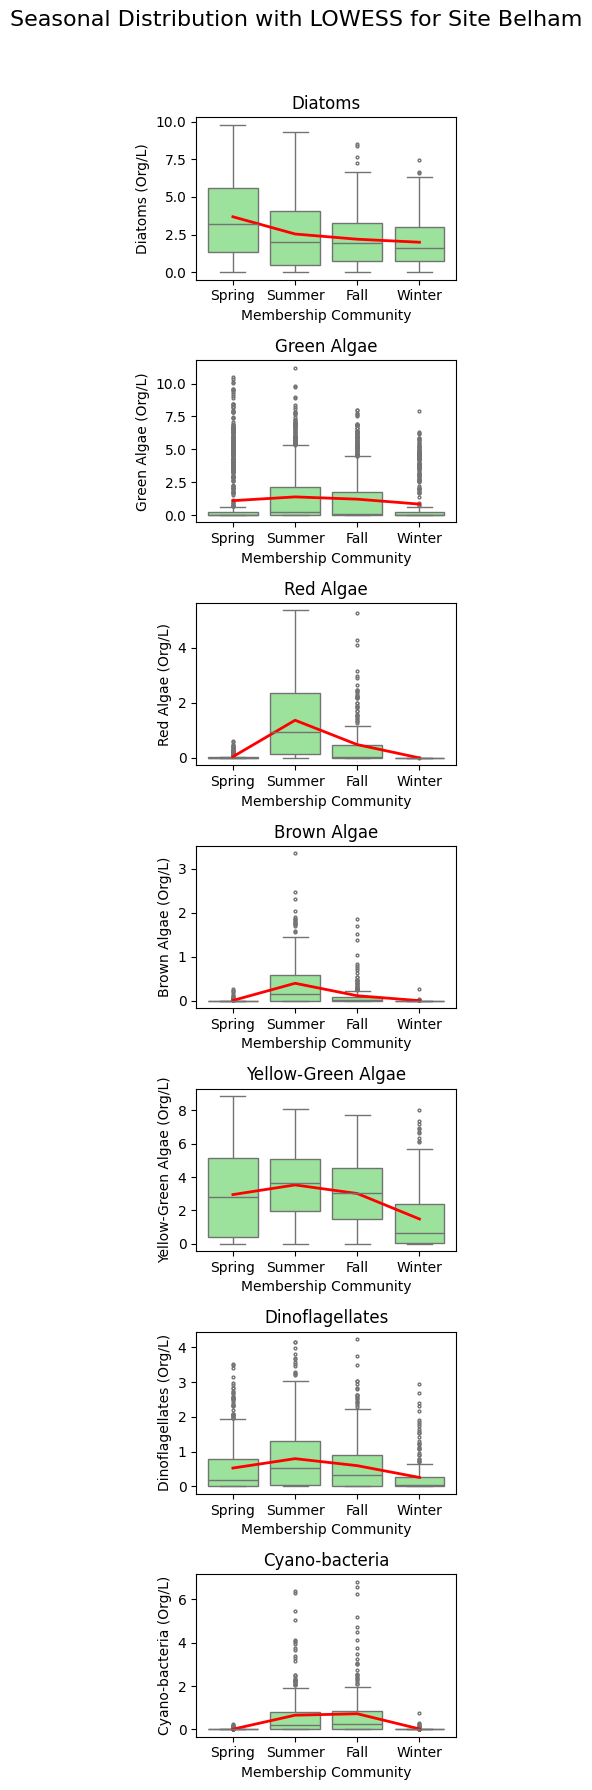

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.

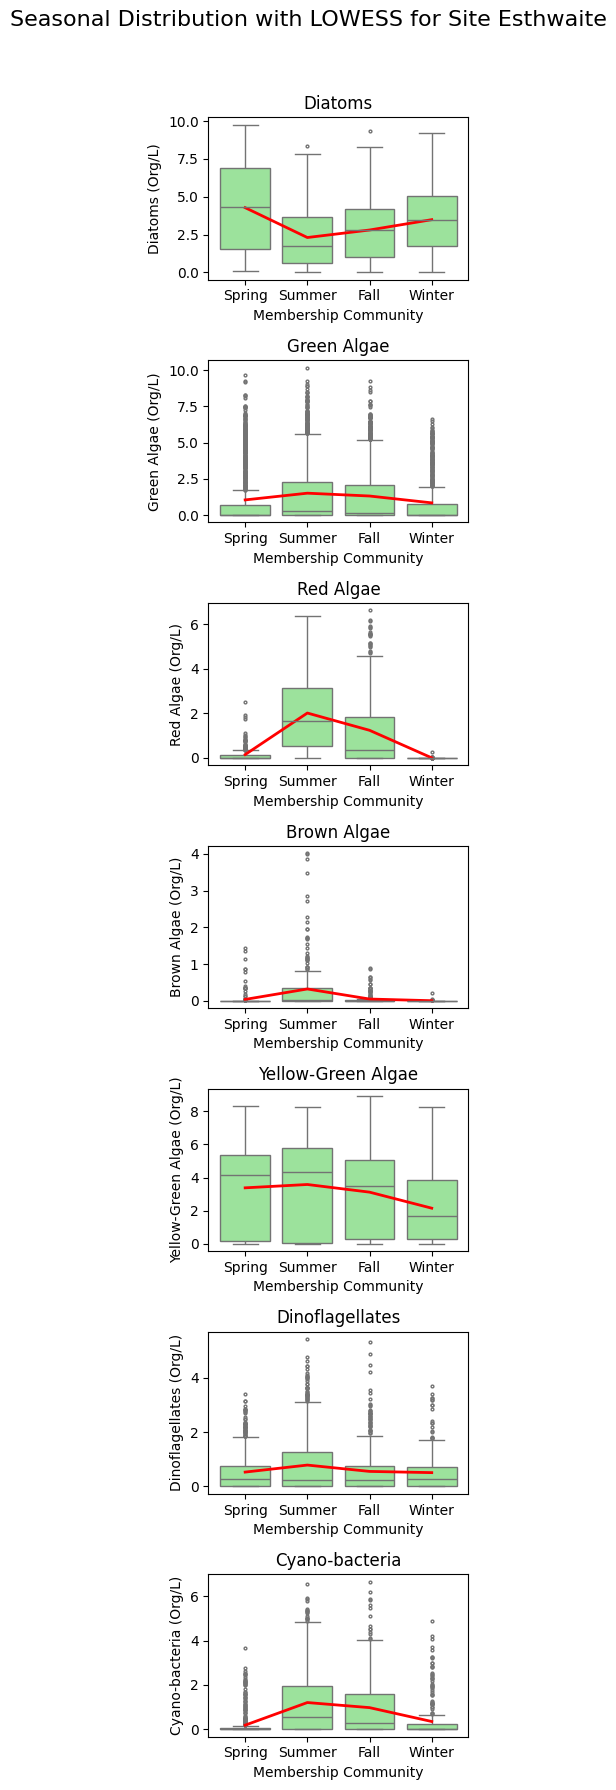

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.

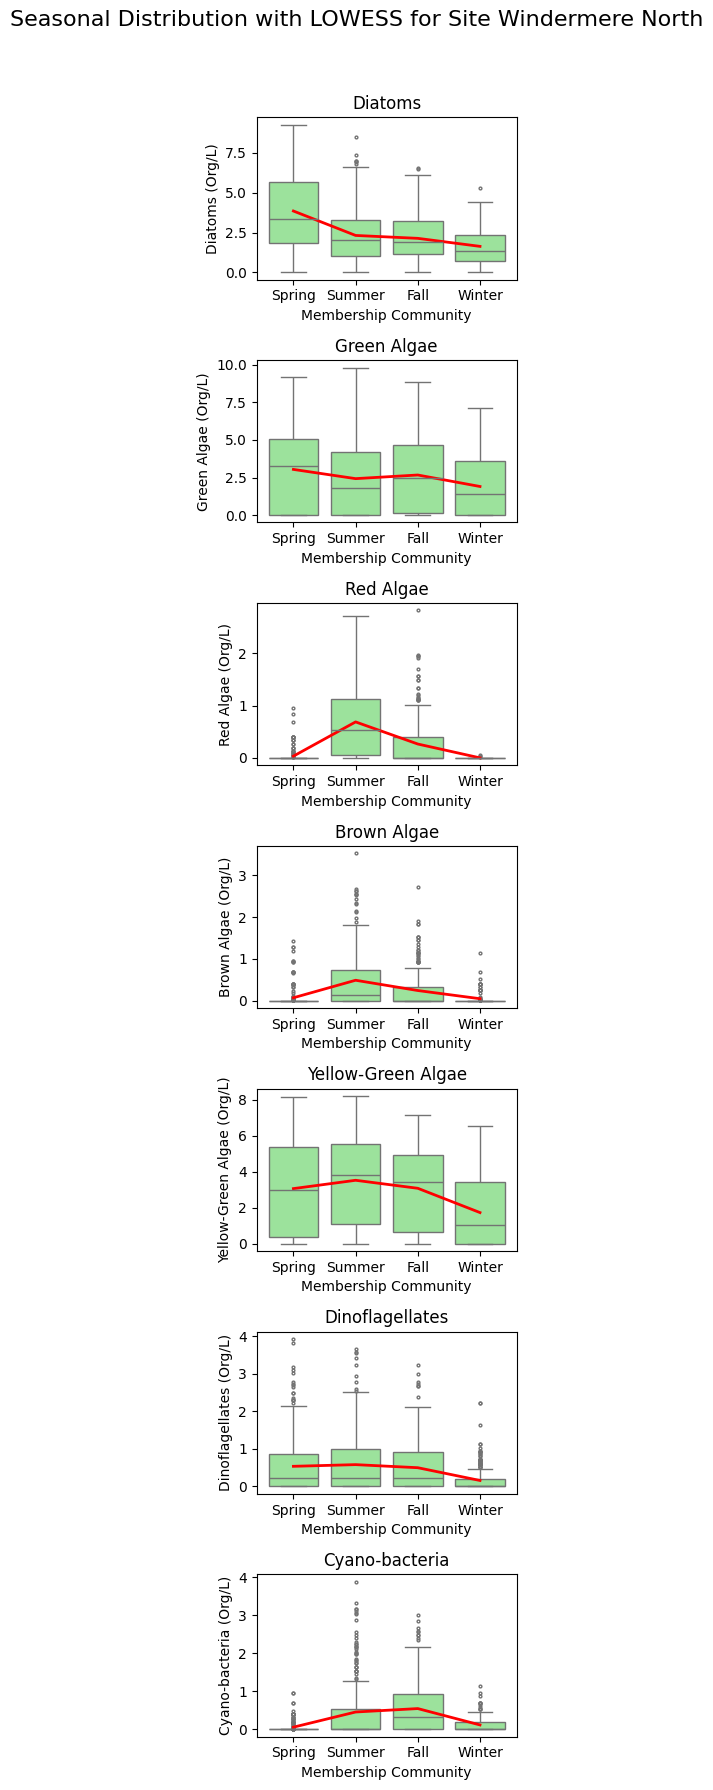

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.

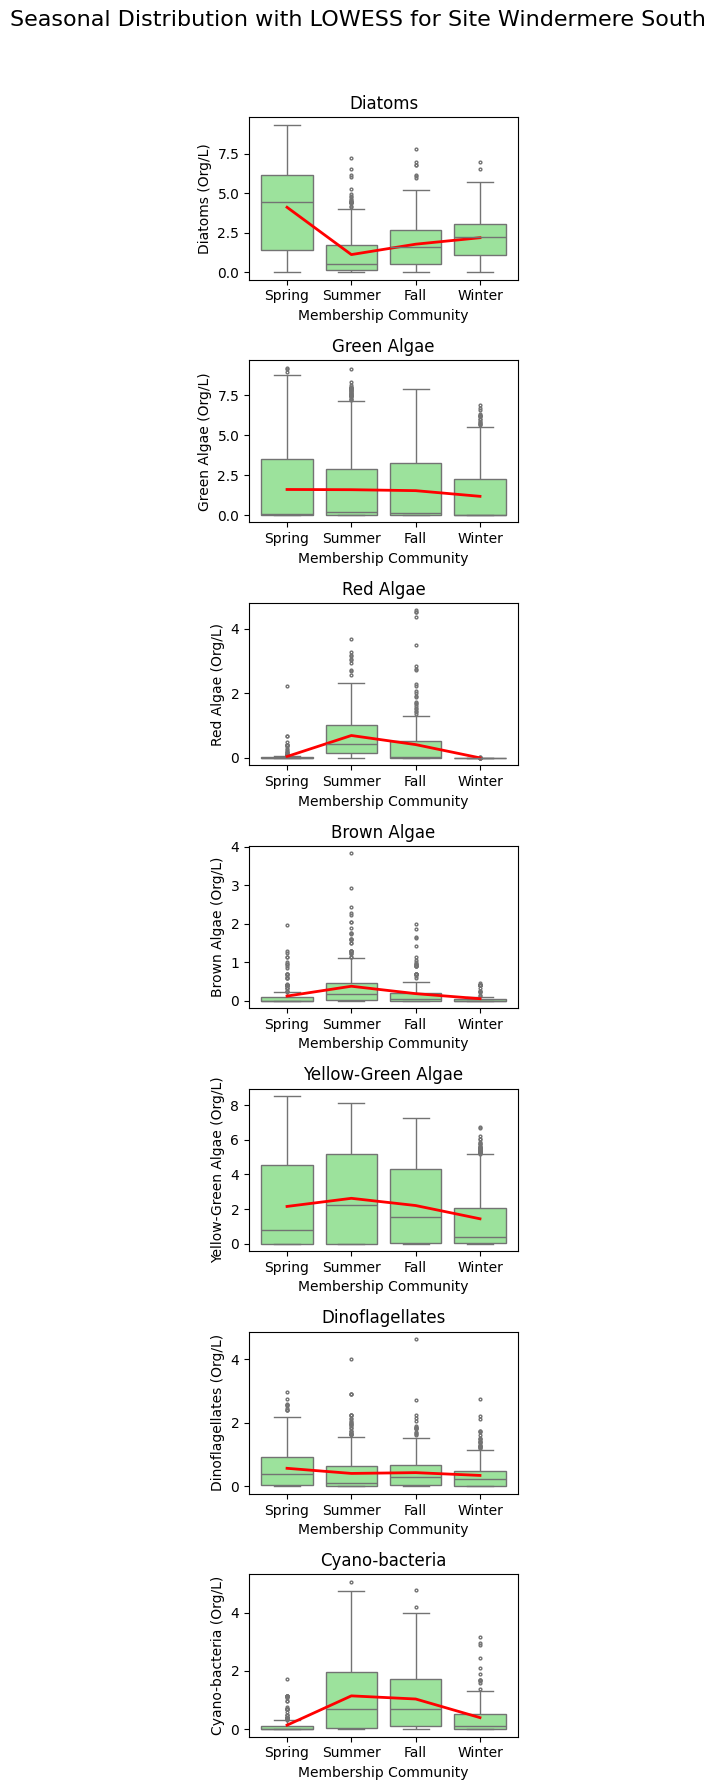

In [364]:
# Seasonal Box plots of each Algae category for each lake

# Extract Month and map to Season
df['Month'] = df['Date'].dt.month

def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'

df['Season'] = df['Month'].apply(get_season)

# Order of seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Log-transform the value column to help scale the boxplots and LOWESS trend
df['log_value'] = np.log1p(df['Value'])  # log1p is log(1+x), to handle zero values

# Map seasons to numerical values for LOWESS
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
df['Season_num'] = df['Season'].map(season_mapping)

# Custom outlier marker (such as arrows for extreme outliers)
flierprops = dict(marker='o', color='red', markersize=2, markeredgewidth=1)  # Smaller arrow for outliers

# Loop over sites
for site in df['Name'].unique():
    site_df = df[df['Name'] == site]

    # Create a subplot for each category with figure size adjusted
    fig, axes = plt.subplots(len(df['Category'].unique()), 1, figsize=(3.5, 2.5 * len(df['Category'].unique())))
    fig.suptitle(f'Seasonal Distribution with LOWESS for Site {site}', fontsize=16, y=1.02)

    # Loop over each category
    for i, category in enumerate(df['Category'].unique()):
        category_data = site_df[site_df['Category'] == category]
        
        # Create a boxplot for each season within each category
        sns.boxplot(
            x='Season', y='log_value', data=category_data, ax=axes[i], color='lightgreen', order=season_order,
            showfliers=True, flierprops=flierprops, whis=1.5  # Adjust outlier detection threshold
        )
        
        # Ensure that the 'Season_num' column is included in season_data
        season_data = category_data.groupby('Season').agg(
            log_value=('log_value', 'mean'),
            Season_num=('Season_num', 'first')  # Ensure 'Season_num' is added for LOWESS
        ).reset_index()

        # Apply LOWESS smoothing directly on the log-transformed values
        lowess_data = lowess(season_data['log_value'], season_data['Season_num'], frac=0.9)

        # Plot the LOWESS trend on top of the boxplot
        axes[i].plot(lowess_data[:, 0], lowess_data[:, 1], color='red', linewidth=2)

        axes[i].set_title(f'{category}')
        axes[i].set_xlabel('Membership Community')
        axes[i].set_ylabel(f'{category} (Org/L)')

    # Adjust the layout for better visibility
    plt.tight_layout()
    plt.show()


This code generates stacked area charts to visualize the relative contributions of different phytoplankton categories by year for each lake site, highlighting the temporal changes in category values.


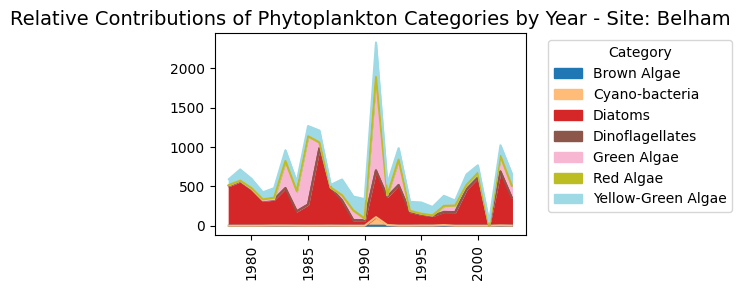

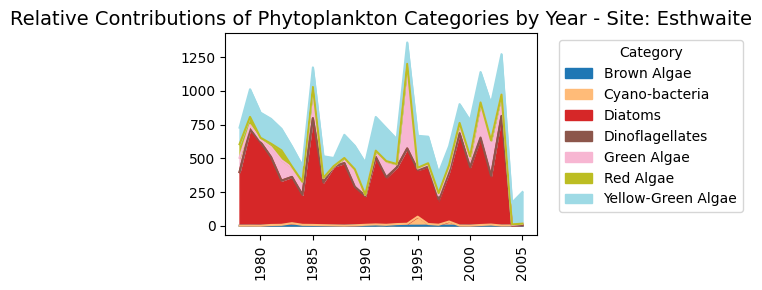

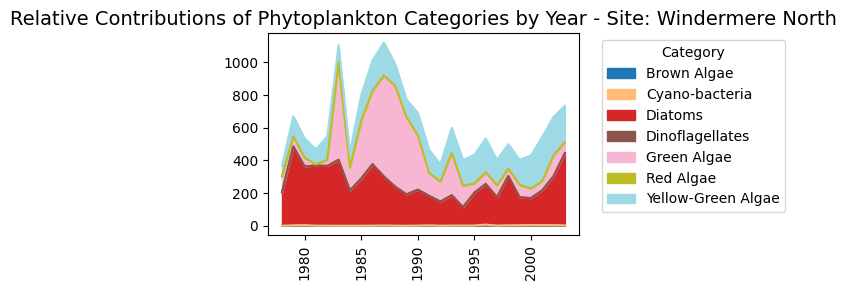

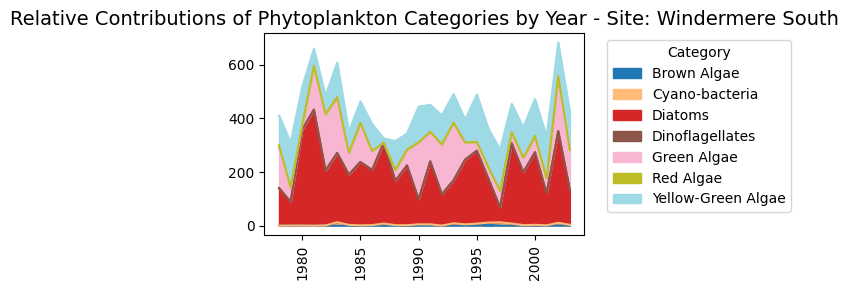

In [366]:
# Ensure 'year' column exists
df['Year'] = df['Date'].dt.year

# Get unique lake sites
sites = df['Name'].unique()

# Loop over each site
for site in sites:
    # Filter data for the current site
    site_df = df[df['Name'] == site]

    # Group by year and category, calculate mean, unstack categories into columns
    yearly_means = site_df.groupby(['Year', 'Category'])['Value'].mean().unstack().fillna(0)

    # Plot stacked area chart
    yearly_means.plot(kind='area', stacked=True, figsize=(6, 3), colormap='tab20')

    plt.title(f'Relative Contributions of Phytoplankton Categories by Year - Site: {site}', fontsize=14)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically to reduce clutter
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

The **ZooFilt dataset** spans from **1983 to 2010** across multiple lakes, with **3,223 entries** and columns for **date**, **year**, **month**, **Name** (lake), and **ZooFilt** values. EDA revealed yearly trends, monthly variations, and seasonal distribution patterns of zooplankton filtration. Boxplots and LOWESS smoothing were used to visualize seasonal variations for each lake.

In [96]:
# Load the dataset
df = pd.read_csv("Cleaned_ZooFilt_Data.csv")
df.head()

date  year  month    Name  ZooFilt
0  20/12/1983  1983     12  Belham      0.0
1  03/01/1984  1984      1  Belham      2.0
2  17/01/1984  1984      1  Belham      3.0
3  28/02/1984  1984      2  Belham      5.0
4  13/03/1984  1984      3  Belham      4.0

In [98]:
df.shape

(3223, 5)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223 entries, 0 to 3222
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     3223 non-null   object 
 1   year     3223 non-null   int64  
 2   month    3223 non-null   int64  
 3   Name     3223 non-null   object 
 4   ZooFilt  3223 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 126.0+ KB


In [102]:
df.describe()

year        month      ZooFilt
count  3223.000000  3223.000000  3223.000000
mean   1991.959044     6.527769    11.988194
std       9.248963     3.169007    18.215846
min    1978.000000     1.000000     0.000000
25%    1985.000000     4.000000     1.500000
50%    1990.000000     7.000000     5.000000
75%    1999.000000     9.000000    15.000000
max    2010.000000    12.000000   240.000000

In [104]:
df.isnull().sum()

date       0
year       0
month      0
Name       0
ZooFilt    0
dtype: int64

This code generates a line plot showing the yearly trend of average zooplankton filtration ("ZooFilt") values for different lakes.

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When 

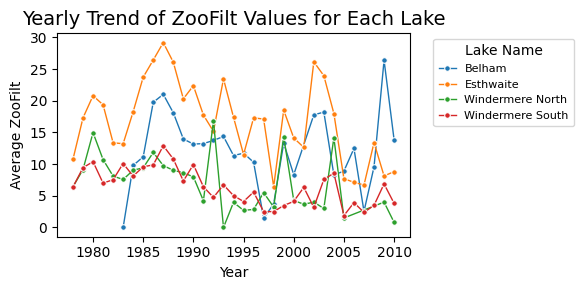

In [106]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Group by 'Name' and 'year' and calculate the mean 'ZooFilt' for each group
yearly_zoo = df.groupby(['Name', 'year'])['ZooFilt'].mean().reset_index()

# Create the plot
plt.figure(figsize=(6, 3))

# Plot the yearly trend for each 'Name' (lake)
sns.lineplot(data=yearly_zoo, x='year', y='ZooFilt', hue='Name', marker='o', markersize=4, linewidth=1)

# Customize plot
plt.title('Yearly Trend of ZooFilt Values for Each Lake', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average ZooFilt')

# Adjust legend box size and font size, keeping the legend box visible
plt.legend(
    title='Lake Name', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=8,             # Reduce font size of legend labels
    title_fontsize=10,      # Reduce font size of legend title
    borderpad=0.5,          # Reduce padding inside the legend box
    labelspacing=0.5,       # Reduce space between labels
    handlelength=1.5,       # Adjust line length in legend
    frameon=True,           # Ensure the frame (box) is present around the legend
    borderaxespad=0.5      # Reduce the padding between the legend box and plot
)

# Adjust the layout so that the legend doesn't overlap
plt.tight_layout()

plt.show()


This code generates separate bar plots displaying the monthly mean zooplankton filtration ("ZooFilt") values for each lake.

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3038783019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lake_data, x='month', y='ZooFilt', palette="Blues_d")
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: Futur

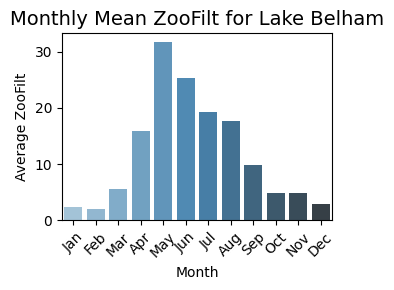

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3038783019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lake_data, x='month', y='ZooFilt', palette="Blues_d")
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: Futur

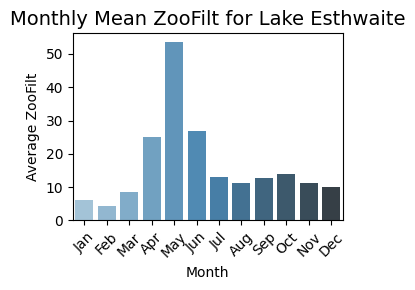

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3038783019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lake_data, x='month', y='ZooFilt', palette="Blues_d")
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: Futur

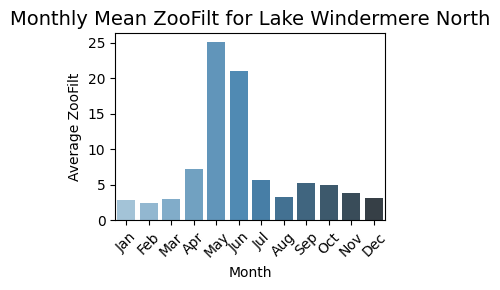

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3038783019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lake_data, x='month', y='ZooFilt', palette="Blues_d")
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: Futur

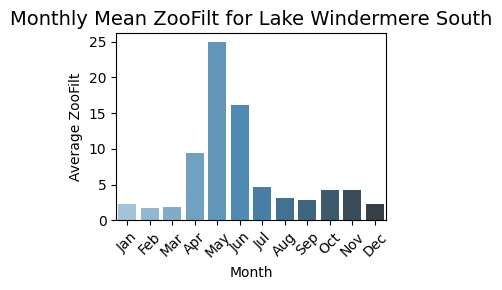

In [112]:
# Group by 'Name', 'month', and calculate the mean 'ZooFilt' for each group
monthly_zoo = df.groupby(['Name', 'month'])['ZooFilt'].mean().reset_index()

# Create separate bar plots for each lake (Name)
lakes = monthly_zoo['Name'].unique()

for lake in lakes:
    # Filter the data for the specific lake
    lake_data = monthly_zoo[monthly_zoo['Name'] == lake]
    
    # Create the plot
    plt.figure(figsize=(3.5, 3))
    sns.barplot(data=lake_data, x='month', y='ZooFilt', palette="Blues_d")
    
    # Customize plot
    plt.title(f'Monthly Mean ZooFilt for Lake {lake}', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel('Average ZooFilt')
    plt.xticks(ticks=range(12), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    
    plt.tight_layout()
    plt.show()

This code generates seasonal boxplots for each lake, displaying the distribution of zooplankton filtration ("ZooFilt") across different seasons, and includes a LOWESS trend line to visualize the seasonal variation in data.

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


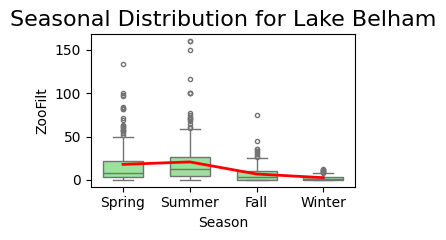

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


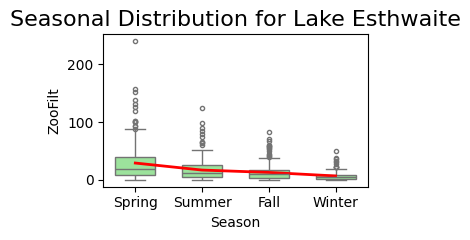

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


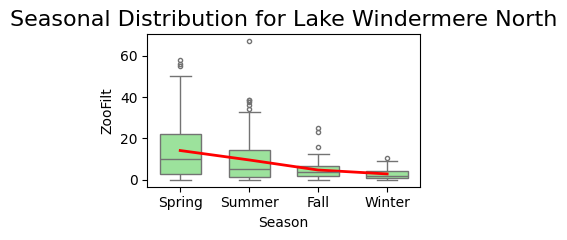

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


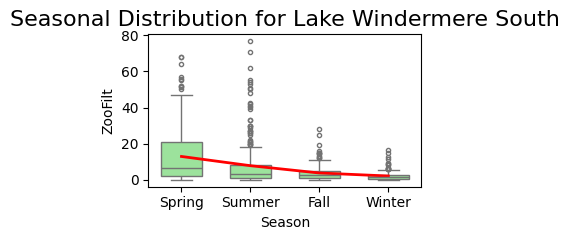

In [110]:

# Extract Month and map to Season
df['Month'] = df['date'].dt.month

def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'

df['Season'] = df['Month'].apply(get_season)

# Order of seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Map seasons to numerical values for LOWESS
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
df['Season_num'] = df['Season'].map(season_mapping)

# Custom outlier marker (adjusted for outliers)
flierprops = dict(marker='o', color='red', markersize=3, markeredgewidth=1)

# Loop over lakes (Names)
for lake in df['Name'].unique():
    lake_df = df[df['Name'] == lake]

    # Create a subplot for each lake
    plt.figure(figsize=(3.5, 2.5))
    plt.title(f'Seasonal Distribution for Lake {lake}', fontsize=16)

    # Create a boxplot for each season
    sns.boxplot(
        x='Season', y='ZooFilt', data=lake_df, order=season_order, 
        showfliers=True, flierprops=flierprops, color='lightgreen', width=0.6
    )

    # Group by season to apply LOWESS smoothing
    season_data = lake_df.groupby('Season').agg(
        ZooFilt=('ZooFilt', 'mean'),
        Season_num=('Season_num', 'first')  # Use 'Season_num' for LOWESS
    ).reset_index()

    # Apply LOWESS smoothing to the data
    lowess_data = lowess(season_data['ZooFilt'], season_data['Season_num'], frac=0.8)

    # Plot the LOWESS trend line
    plt.plot(lowess_data[:, 0], lowess_data[:, 1], color='red', linewidth=2)

    # Customizing the plot
    plt.xlabel('Season')
    plt.ylabel('ZooFilt')
    plt.tight_layout()
    plt.show()


The dataset contains 707 entries from 1979 to 2010, tracking zooplankton populations (Bosmina, Daphnia, Calanoids, Cyclopoids) in Windermere North. EDA reveals distinct monthly and seasonal patterns using barplots, boxplots, and LOWESS trends. Results highlight species-wise seasonal variation and long-term temporal shifts across decades.

In [136]:
# Load the dataset
df = pd.read_csv("Cleaned_WindermereNorth_Plankton_Data.csv")
df.head()

Date  Year  Month              Name  Bosmina  Daphnia  TotCalanoids  \
0  09/01/1979  1979      1  Windermere North     0.17     0.18          2.20   
1  23/01/1979  1979      1  Windermere North     0.04     0.14          1.38   
2  20/02/1979  1979      2  Windermere North     0.04     0.10          1.50   
3  06/03/1979  1979      3  Windermere North     0.05     0.04          1.03   
4  20/03/1979  1979      3  Windermere North     0.04     0.08          0.97   

   TotCyclopoids  ZooFilt  
0           0.04      5.0  
1           0.00      4.0  
2           0.00      4.0  
3           0.01      2.0  
4           0.00      3.0

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           707 non-null    object 
 1   Year           707 non-null    int64  
 2   Month          707 non-null    int64  
 3   Name           707 non-null    object 
 4   Bosmina        707 non-null    float64
 5   Daphnia        707 non-null    float64
 6   TotCalanoids   707 non-null    float64
 7   TotCyclopoids  707 non-null    float64
 8   ZooFilt        707 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 49.8+ KB


In [140]:
df.shape

(707, 9)

In [142]:
df.describe()

Year       Month     Bosmina     Daphnia  TotCalanoids  \
count   707.000000  707.000000  707.000000  707.000000    707.000000   
mean   1994.978784    6.417256    0.145290    0.200255      0.625884   
std       9.180028    3.332795    0.373853    0.357109      0.524566   
min    1979.000000    1.000000    0.000000    0.000000      0.000000   
25%    1987.500000    4.000000    0.010000    0.030000      0.250000   
50%    1995.000000    6.000000    0.030000    0.070000      0.500000   
75%    2003.000000    9.000000    0.110000    0.180000      0.850000   
max    2010.000000   12.000000    3.360000    3.660000      3.920000   

       TotCyclopoids     ZooFilt  
count     707.000000  707.000000  
mean        0.550141    6.223423  
std         0.726118    9.659044  
min         0.000000    0.000000  
25%         0.030000    1.000000  
50%         0.220000    3.000000  
75%         0.870000    6.500000  
max         4.520000   71.500000

In [146]:
df.isnull().sum()

Date             0
Year             0
Month            0
Name             0
Bosmina          0
Daphnia          0
TotCalanoids     0
TotCyclopoids    0
ZooFilt          0
dtype: int64

This code plots the yearly trends of four species (Bosmina, Daphnia, TotCalanoids, TotCyclopoids) in Windermere North (1979-2010), displaying average values per year.

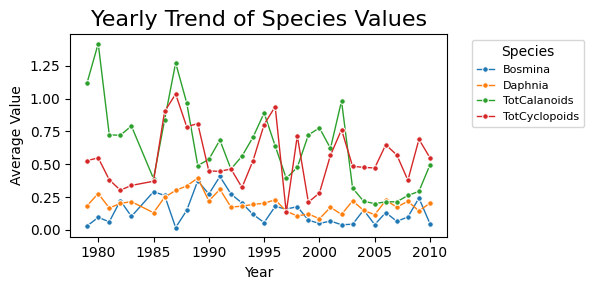

In [148]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Group by 'Year' and calculate the mean for each species column
yearly_data = df.groupby('Year')[['Bosmina', 'Daphnia', 'TotCalanoids', 'TotCyclopoids']].mean().reset_index()

# Create the plot
plt.figure(figsize=(6, 3))

# Plot each variable with a separate line and marker
sns.lineplot(data=yearly_data, x='Year', y='Bosmina', label='Bosmina', marker='o', markersize=4, linewidth=1)
sns.lineplot(data=yearly_data, x='Year', y='Daphnia', label='Daphnia', marker='o', markersize=4, linewidth=1)
sns.lineplot(data=yearly_data, x='Year', y='TotCalanoids', label='TotCalanoids', marker='o', markersize=4, linewidth=1)
sns.lineplot(data=yearly_data, x='Year', y='TotCyclopoids', label='TotCyclopoids', marker='o', markersize=4, linewidth=1)

# Customize plot
plt.title('Yearly Trend of Species Values', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Value')

# Adjust legend box size and font size, keeping the legend box visible
plt.legend(
    title='Species', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=8,             # Reduce font size of legend labels
    title_fontsize=10,      # Reduce font size of legend title
    borderpad=0.5,          # Reduce padding inside the legend box
    labelspacing=0.5,       # Reduce space between labels
    handlelength=1.5,       # Adjust line length in legend
    frameon=True,           # Ensure the frame (box) is present around the legend
    borderaxespad=0.5      # Reduce the padding between the legend box and plot
)

# Adjust the layout so that the legend doesn't overlap
plt.tight_layout()

plt.show()

This code generates separate bar plots for the monthly mean values of four species (Bosmina, Daphnia, TotCalanoids, TotCyclopoids).

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3034788973.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_values, x='Month', y=param, palette="Blues_d")  # Set color to blue
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seabo

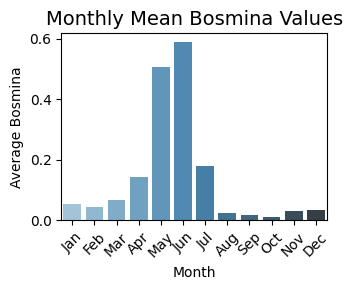

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3034788973.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_values, x='Month', y=param, palette="Blues_d")  # Set color to blue
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seabo

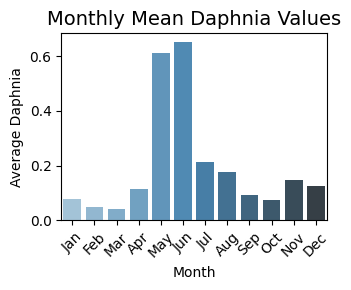

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3034788973.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_values, x='Month', y=param, palette="Blues_d")  # Set color to blue
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seabo

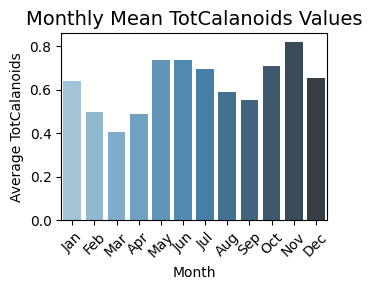

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3034788973.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_values, x='Month', y=param, palette="Blues_d")  # Set color to blue
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP\anaconda3\lib\site-packages\seabo

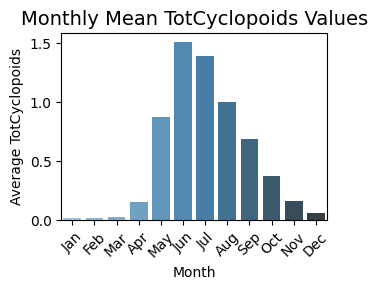

In [150]:
# Group by 'Month' and calculate the mean for each group
monthly_values = df.groupby(['Month'])[['Bosmina', 'Daphnia', 'TotCalanoids', 'TotCyclopoids']].mean().reset_index()

# Create separate bar plots for each parameter
parameters = ['Bosmina', 'Daphnia', 'TotCalanoids', 'TotCyclopoids']

for param in parameters:
    # Create the plot for each parameter
    plt.figure(figsize=(3.5, 3))
    sns.barplot(data=monthly_values, x='Month', y=param, palette="Blues_d")  # Set color to blue
    
    # Customize plot
    plt.title(f'Monthly Mean {param} Values', fontsize=14)
    plt.xlabel('Month')
    plt.ylabel(f'Average {param}')
    plt.xticks(ticks=range(12), labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    
    plt.tight_layout()
    plt.show()


This code creates seasonal boxplots for each parameter (Bosmina, Daphnia, TotCalanoids, TotCyclopoids), with LOWESS smoothing applied to highlight trends across different seasons (Spring, Summer, Fall, Winter).

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


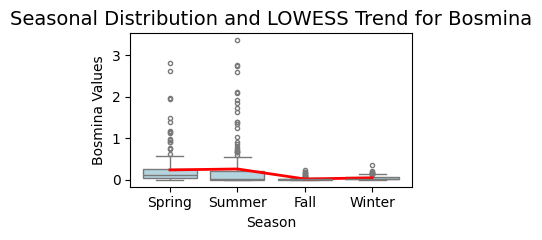

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


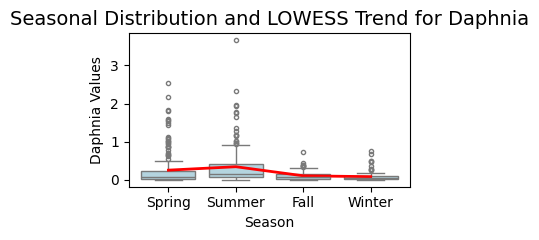

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


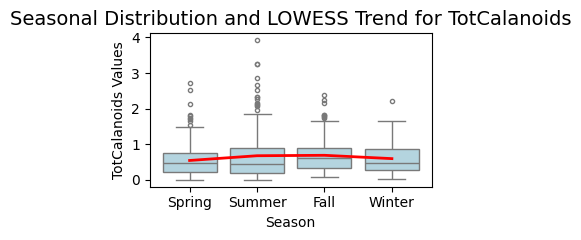

C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


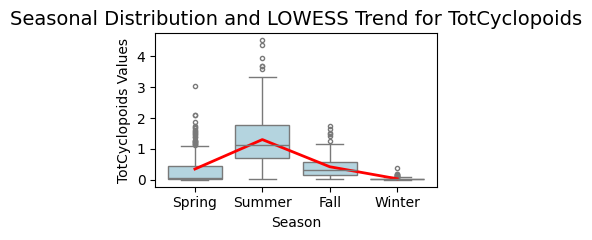

In [152]:
# Extract Month and map to Season
df['Month'] = df['Date'].dt.month

def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'

df['Season'] = df['Month'].apply(get_season)

# Order of seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# List of parameters for which we want seasonal boxplots
parameters = ['Bosmina', 'Daphnia', 'TotCalanoids', 'TotCyclopoids']
# Custom outlier marker (adjusted for outliers)
flierprops = dict(marker='o', color='red', markersize=3, markeredgewidth=1)
# Loop over each parameter
for param in parameters:
    plt.figure(figsize=(3.5, 2.5))
    
    # Create a boxplot for each season
    sns.boxplot(x='Season', y=param, data=df, order=season_order, color='lightblue',flierprops=flierprops)
    
    # Apply LOWESS smoothing on the parameter values for the seasons
    season_data = df.groupby('Season')[param].mean().reset_index()
    
    # Mapping seasons to numerical values for LOWESS
    season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
    season_data['Season_num'] = season_data['Season'].map(season_mapping)

    # Apply LOWESS smoothing
    lowess_data = lowess(season_data[param], season_data['Season_num'], frac=0.8)

    # Plot the LOWESS trend
    plt.plot(lowess_data[:, 0], lowess_data[:, 1], color='red', linewidth=2, label='LOWESS Trend')

    # Customize plot
    plt.title(f'Seasonal Distribution and LOWESS Trend for {param}', fontsize=14)
    plt.xlabel('Season')
    plt.ylabel(f'{param} Values')

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.show()


The **Belham Humidity dataset** contains 2,713 entries from **2012 to 2019**, capturing **hourly humidity readings** across 24 hours each day. The exploratory data analysis (EDA) reveals that the dataset allows for the analysis of **yearly** and **monthly humidity trends**, with calculations of **average humidity** for each year and month. Visualizations highlight **seasonal** and **temporal patterns**, providing insights into diurnal and seasonal variations in humidity levels. This dataset is useful for tracking changes in humidity over time and identifying seasonal patterns.

In [114]:
df = pd.read_csv("Cleaned_Belham_Humidity_Data.csv")
df.head()

Date       1.0       2.0       3.0       4.0       5.0       6.0  \
0  2012-01-01  92.06827  91.59800  90.96807  91.34733  91.55733  87.52533   
1  2012-01-02  75.39880  72.53027  76.14867  73.34527  74.51447  71.22347   
2  2012-01-03  83.93267  89.87753  91.08113  95.34013  96.45253  93.21953   
3  2012-01-04  68.37220  78.14313  75.81360  76.59500  75.71440  78.99613   
4  2012-01-05  69.38127  72.63860  72.12360  73.79080  72.45613  71.64053   

        7.0       8.0       9.0  ...      15.0      16.0      17.0      18.0  \
0  85.58707  90.46240  91.75413  ...  86.45453  82.63573  82.56627  80.96433   
1  76.48260  72.70000  76.17113  ...  76.53440  79.04753  82.96980  83.42920   
2  92.50260  73.97527  67.25593  ...  66.54607  68.34907  69.92107  75.15013   
3  77.07613  75.76180  74.87753  ...  85.88560  86.83927  86.90993  83.73300   
4  71.63140  79.07540  74.74160  ...  57.49407  59.63840  61.22693  61.31473   

       19.0      20.0      21.0      22.0      23.0      24.0  
0  82.81400  80.11780  74.51713  79.47993  79.71053  75.06020  
1  79.47640  79.46913  77.72020  82.61987  81.90860  81.33100  
2  74.67740  72.73433  79.69280  71.43733  74.64247  69.64047  
3  86.78680  85.14653  83.62927  79.86467  79.14200  77.29880  
4  63.01227  65.54967  67.13680  68.06580  65.65253  68.21087  

[5 rows x 25 columns]

In [116]:
df.shape

(2713, 25)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2713 non-null   object 
 1   1.0     2713 non-null   float64
 2   2.0     2713 non-null   float64
 3   3.0     2713 non-null   float64
 4   4.0     2713 non-null   float64
 5   5.0     2713 non-null   float64
 6   6.0     2713 non-null   float64
 7   7.0     2713 non-null   float64
 8   8.0     2713 non-null   float64
 9   9.0     2713 non-null   float64
 10  10.0    2713 non-null   float64
 11  11.0    2713 non-null   float64
 12  12.0    2713 non-null   float64
 13  13.0    2713 non-null   float64
 14  14.0    2713 non-null   float64
 15  15.0    2713 non-null   float64
 16  16.0    2713 non-null   float64
 17  17.0    2713 non-null   float64
 18  18.0    2713 non-null   float64
 19  19.0    2713 non-null   float64
 20  20.0    2713 non-null   float64
 21  21.0    2713 non-null   float64
 22  

In [120]:
df.describe()

1.0          2.0          3.0          4.0          5.0  \
count  2713.000000  2713.000000  2713.000000  2713.000000  2713.000000   
mean     90.661524    91.082036    91.454793    91.804514    92.070130   
std       8.816822     8.728881     8.722933     8.586698     8.534982   
min      39.806130    55.104470    51.731600    50.408000    52.585930   
25%      85.696330    86.264470    86.683730    87.275130    87.231070   
50%      93.884870    94.236730    94.818600    95.264670    95.517070   
75%      97.535670    97.915000    98.247400    98.477330    98.708330   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

               6.0          7.0          8.0          9.0         10.0  ...  \
count  2713.000000  2713.000000  2713.000000  2713.000000  2713.000000  ...   
mean     92.105414    91.367757    89.681638    87.233138    84.508713  ...   
std       8.602214     9.039723     9.886182    11.148605    12.476263  ...   
min      48.456330    51.035000    43.609470    37.309000    34.667670  ...   
25%      87.182670    85.811470    83.092000    79.136670    75.278930  ...   
50%      95.568870    94.679330    92.803870    89.572670    86.150600  ...   
75%      98.992200    98.897670    98.227330    97.151270    95.654670  ...   
max     100.000000   100.000000   100.000000   100.000000   100.000000  ...   

              15.0         16.0         17.0         18.0         19.0  \
count  2713.000000  2713.000000  2713.000000  2713.000000  2713.000000   
mean     75.779207    76.127238    77.119384    79.077422    81.500677   
std      14.454091    14.554942    14.417604    13.846326    12.980498   
min      25.725530    25.986270    27.402330    33.556730    36.488930   
25%      65.785335    66.275070    67.073470    69.704870    73.104870   
50%      76.004067    76.320330    78.028870    80.582070    83.344270   
75%      87.797130    88.029600    89.040803    90.553470    92.362130   
max     100.000000   100.000000   100.000000   100.000000   100.000000   

              20.0         21.0         22.0         23.0         24.0  
count  2713.000000  2713.000000  2713.000000  2713.000000  2713.000000  
mean     84.105535    86.396140    88.079855    89.347008    90.057764  
std      11.568284    10.152414     9.388727     8.961553     8.935224  
min      36.139000    46.071870    51.722330    48.471930    50.495730  
25%      76.442930    79.320200    81.819000    83.698930    85.133070  
50%      86.348470    88.531000    90.623130    92.072470    93.086400  
75%      93.693470    94.858330    95.809000    96.536930    97.134930  
max     100.000000   100.000000   100.000000   100.000000   100.000000  

[8 rows x 24 columns]

In [122]:
df.isnull().sum()

Date    0
1.0     0
2.0     0
3.0     0
4.0     0
5.0     0
6.0     0
7.0     0
8.0     0
9.0     0
10.0    0
11.0    0
12.0    0
13.0    0
14.0    0
15.0    0
16.0    0
17.0    0
18.0    0
19.0    0
20.0    0
21.0    0
22.0    0
23.0    0
24.0    0
dtype: int64

This code processes Belham's hourly humidity data (2012–2019) by calculating yearly averages across 24 hours per day. It then visualizes these trends using a line plot to highlight year-to-year variations and potential long-term changes in humidity levels.

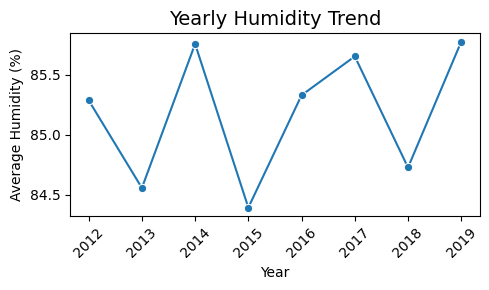

In [124]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract the Year from the 'Date' column
df['Year'] = df['Date'].dt.year

# List of columns related to hourly humidity data (assuming humidity data is in columns 1.0, 2.0, ..., 24.0)
humidity_columns = [str(i) + '.0' for i in range(1, 25)]

# Group by year and calculate the average humidity for each year
yearly_avg_humidity = df.groupby('Year')[humidity_columns].mean().reset_index()

# Calculate the overall mean for each year across all hours
yearly_avg_humidity['Average Humidity'] = yearly_avg_humidity[humidity_columns].mean(axis=1)

# Create the plot
plt.figure(figsize=(5, 3))

# Plot the average humidity for each year
sns.lineplot(data=yearly_avg_humidity, x='Year', y='Average Humidity', marker='o')

# Customize plot
plt.title('Yearly Humidity Trend', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


This code analyzes Belham’s hourly humidity data by calculating average humidity for each month (across all 24 hours) and visualizing the results as a line plot. The monthly trend helps identify seasonal humidity patterns throughout the year.

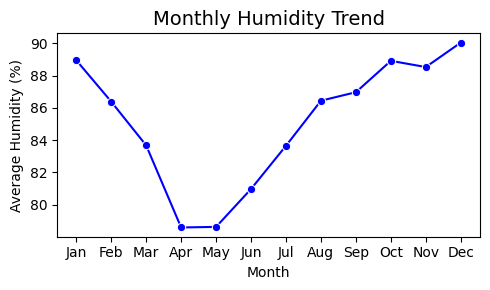

In [132]:
# Extract the Month from the 'Date' column
df['Month'] = df['Date'].dt.month

# List of columns related to hourly humidity data (assuming humidity data is in columns 1.0, 2.0, ..., 24.0)
humidity_columns = [str(i) + '.0' for i in range(1, 25)]

# Group by Month and calculate the average humidity for each month
monthly_avg_humidity = df.groupby('Month')[humidity_columns].mean().reset_index()

# Calculate the overall mean humidity for each month across all hours
monthly_avg_humidity['Average Humidity'] = monthly_avg_humidity[humidity_columns].mean(axis=1)

# Create the plot
plt.figure(figsize=(5, 3))

# Plot the monthly average humidity trend
sns.lineplot(data=monthly_avg_humidity, x='Month', y='Average Humidity', marker='o', color='blue')

# Customize plot
plt.title('Monthly Humidity Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average Humidity (%)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

plt.show()

The **Belham Water Monitoring dataset** spans from **2008 to 2015**, containing 2,887 entries with water temperature readings at various depths, along with wind speed, pyranometer data, and air temperature. The dataset supports analysis of **seasonal and yearly trends** in water temperatures, and relationships with environmental factors. Exploratory Data Analysis (EDA) includes trends across months and years, correlations with environmental variables, and visualizations of temperature distributions using boxplots and LOWESS smoothing.

In [154]:
df = pd.read_csv('Cleaned_Belham_WaterMonitoring_Data.csv')

In [156]:
df.head()

Date      0.5m        1m        2m        3m        4m        5m  \
0  2008-01-01  6.231274  6.012752  5.774700  5.789170  5.720326  5.596057   
1  2008-01-02  6.331563  6.112267  5.936946  5.901958  5.818392  5.622100   
2  2008-01-03  5.639496  5.639371  5.597433  5.632867  5.629479  5.484833   
3  2008-01-04  5.295888  5.301429  5.263229  5.292458  5.293879  5.169629   
4  2008-01-05  5.197496  5.194248  5.126996  5.178560  5.182532  5.084996   

         6m        7m        8m        9m       10m       12m  \
0  5.666270  5.630270  5.489074  5.540083  5.383887  4.953109   
1  5.746871  5.682371  5.540242  5.582500  5.444492  5.000350   
2  5.613317  5.592975  5.506788  5.594275  5.549654  5.151925   
3  5.284738  5.270113  5.202629  5.302521  5.246279  5.079583   
4  5.184352  5.180460  5.119872  5.239672  5.222300  5.003384   

   Air Temperature  Pyranometer  Wind Speed  
0         7.456361     4.959128    0.147505  
1         5.125671     4.684967    2.116761  
2         2.108371    18.138972    3.192384  
3         3.013448    10.718405    1.405229  
4         6.875500    23.530304    4.093003

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2887 entries, 0 to 2886
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2887 non-null   object 
 1   0.5m             2887 non-null   float64
 2   1m               2887 non-null   float64
 3   2m               2887 non-null   float64
 4   3m               2887 non-null   float64
 5   4m               2887 non-null   float64
 6   5m               2887 non-null   float64
 7   6m               2887 non-null   float64
 8   7m               2887 non-null   float64
 9   8m               2887 non-null   float64
 10  9m               2887 non-null   float64
 11  10m              2887 non-null   float64
 12  12m              2887 non-null   float64
 13  Air Temperature  2887 non-null   float64
 14  Pyranometer      2887 non-null   float64
 15  Wind Speed       2887 non-null   float64
dtypes: float64(15), object(1)
memory usage: 361.0+ KB


In [160]:
df.shape

(2887, 16)

In [162]:
df.describe()

0.5m           1m           2m           3m           4m  \
count  2887.000000  2887.000000  2887.000000  2887.000000  2887.000000   
mean     11.287860    11.207067    10.907987    10.509291    10.020656   
std       5.387160     5.275746     4.974212     4.601163     4.109280   
min       1.962625     2.588971     2.938830     2.975239     2.980288   
25%       6.179294     6.175922     6.140346     6.104701     6.102476   
50%      11.166427    11.057974    10.893583    10.694116    10.436749   
75%      16.185354    16.035073    15.567604    14.826562    13.813167   
max      25.464037    24.825324    23.669463    21.101110    18.331193   

                5m           6m           7m           8m           9m  \
count  2887.000000  2887.000000  2887.000000  2887.000000  2887.000000   
mean      9.337072     8.697881     8.046306     7.539963     7.305547   
std       3.532822     2.935740     2.417353     2.056257     1.874744   
min       2.871509     2.957048     3.021009     3.092895     3.191109   
25%       6.002341     6.019343     5.991214     5.912906     5.868328   
50%       9.667080     9.074883     8.397800     7.984233     7.807188   
75%      12.457479    11.269875    10.043713     9.053683     8.679198   
max      15.819686    13.953583    13.105625    12.316625    11.780208   

               10m          12m  Air Temperature  Pyranometer   Wind Speed  
count  2887.000000  2887.000000      2887.000000  2887.000000  2887.000000  
mean      7.189009     7.117090         9.380692   102.852824     1.721389  
std       1.803644     1.717373         4.901365    85.821502     1.297325  
min       3.242749     3.275712       -10.266992    -3.814810     0.000000  
25%       5.839265     5.806242         6.075619    28.448319     0.806444  
50%       7.706158     7.674485         9.644386    79.689639     1.392292  
75%       8.553660     8.464971        13.326097   158.531437     2.332198  
max      10.810917    10.233083        22.294458   365.321055     8.711728

In [164]:
df.isnull().sum()

Date               0
0.5m               0
1m                 0
2m                 0
3m                 0
4m                 0
5m                 0
6m                 0
7m                 0
8m                 0
9m                 0
10m                0
12m                0
Air Temperature    0
Pyranometer        0
Wind Speed         0
dtype: int64

The code processes the **Belham Water Monitoring dataset**, focusing on **monthly average water temperatures** at various depths, and visualizes the results across different months. It calculates the temperature for depths from **0.5m to 12m** and creates a line plot showing the temperature trends.

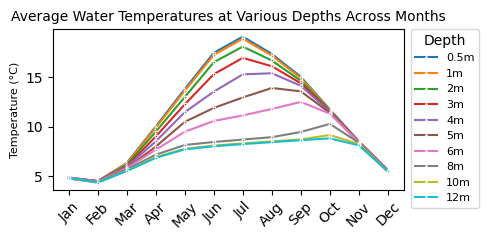

In [166]:
# Convert 'Date' column to datetime, if not already in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract the Month from the 'Date' column
df['Month'] = df['Date'].dt.month

# Drop rows where 'Month' is NaN (invalid date entries)
df = df.dropna(subset=['Month'])

# List of columns related to water temperature at different depths
temperature_columns = ['0.5m','1m', '2m', 
                       '3m', '4m',
                       '5m', '6m',
                       '8m', '10m',
                       '12m']

# Map month numbers to month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Calculate average monthly temperature for each depth
monthly_avg = df.groupby(['Month'])[temperature_columns].mean().reset_index()

# Convert 'Month' to integers and replace month numbers with month names
monthly_avg['Month_Name'] = monthly_avg['Month'].astype(int).apply(lambda x: month_names[x-1])

# Create the plot
plt.figure(figsize=(5, 2.5))  # Slightly wider for better spacing

# Plot each temperature column with smaller markers
for col in temperature_columns:
    sns.lineplot(data=monthly_avg, x='Month_Name', y=col, marker='o', markersize=2, label=col)

plt.title('Average Water Temperatures at Various Depths Across Months', fontsize = 10)
plt.xlabel('')
plt.ylabel('Temperature (°C)', fontsize = 8)
plt.xticks(rotation=45)

# Move and shrink legend
plt.legend(
    title='Depth',
    fontsize = 4,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 8},      # Smaller font in legend
    markerscale=0.6        # Smaller markers in legend
)

plt.tight_layout()
plt.show()


The code calculates and visualizes the **correlation** between **water temperatures** at different depths (ranging from **0.5m to 12m**) and two environmental variables: **Wind Speed** and **Pyranometer**. It computes the pairwise correlations and displays the results in a heatmap, where each cell represents the correlation coefficient between the corresponding temperature depth and environmental variable.

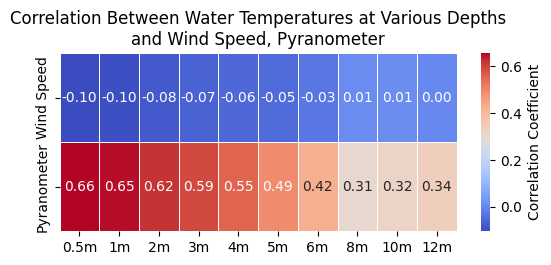

In [168]:
# Define columns
depth_columns = ['0.5m', '1m', '2m', '3m', '4m', '5m', '6m',
                 '8m', '10m', '12m']
target_columns = [ 'Wind Speed', 'Pyranometer']

# Initialize an empty DataFrame to store correlations
correlation_values = pd.DataFrame(index=target_columns, columns=depth_columns)

# Compute pairwise correlations
for target in target_columns:
    for depth in depth_columns:
        correlation_values.loc[target, depth] = df[target].corr(df[depth])

# Convert to float for heatmap
correlation_values = correlation_values.astype(float)

# Plot the heatmap
plt.figure(figsize=(5.5, 2.75))
sns.heatmap(correlation_values, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
           cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Between Water Temperatures at Various Depths\nand Wind Speed, Pyranometer', fontsize=12)
plt.tight_layout()
plt.show()

In [170]:
correlation = df['Air Temperature'].corr(df['Wind Speed'])
print(f"Correlation between Air Temperature and Wind Speed: {correlation:.2f}")


Correlation between Air Temperature and Wind Speed: 0.10


In [172]:
correlation = df['Air Temperature'].corr(df['Pyranometer'])
print(f"Correlation between Air Temperature and Pyranometer: {correlation:.2f}")


Correlation between Air Temperature and Pyranometer: 0.51


This code calculates and visualizes the **average yearly water temperatures** at various depths (from **0.5m to 12m**) in a line plot, helping to track how temperature changes over the years. Each line represents the temperature at a specific depth, and the plot includes a legend showing the corresponding depths.

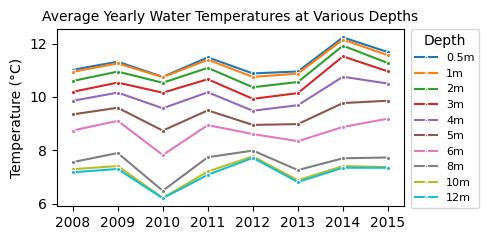

In [174]:
# Extract the Year from the 'Date' column
df['Year'] = df['Date'].dt.year

# List of columns related to water temperature at different depths
temperature_columns = ['0.5m','1m', '2m', 
                       '3m', '4m',
                       '5m', '6m',
                       '8m', '10m',
                       '12m']

# Group by year and calculate average temperature for each depth
yearly_avg = df.groupby('Year')[temperature_columns].mean().reset_index()

# Create the plot
plt.figure(figsize=(5,2.5))  # Adjust width for legend space

# Plot each temperature column with smaller markers
for col in temperature_columns:
    sns.lineplot(data=yearly_avg, x='Year', y=col, marker='o', markersize=3, label=col)

plt.title('Average Yearly Water Temperatures at Various Depths', fontsize = 10)
plt.xlabel('')
plt.ylabel('Temperature (°C)')

# Move and shrink legend
plt.legend(
    title='Depth',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 8},
    markerscale=0.6
)

plt.tight_layout()
plt.show()

This code visualizes the **distribution of water temperatures** at various depths using a **boxplot** and overlays a **LOWESS** (Locally Weighted Scatterplot Smoothing) line to show the smoothed mean temperature trend across different depths. The boxplot helps identify the spread of temperature values, while the LOWESS line highlights the overall temperature trend, smoothing out any fluctuations.

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\3984634704.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


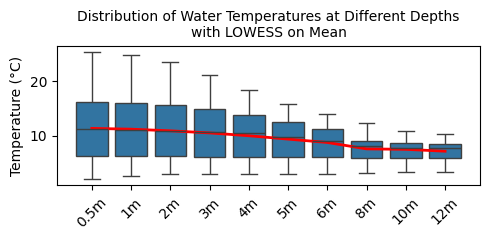

In [176]:
# Melt the dataframe for easier plotting
df_melted = df.melt(
    id_vars=['Date'],
    value_vars=temperature_columns,
    var_name='Depth',
    value_name='Temperature'
)

# Convert 'Depth' to ordered categorical type if needed for correct plotting
depth_order = sorted(temperature_columns, key=lambda x: float(x.replace('m', '')))
df_melted['Depth'] = pd.Categorical(df_melted['Depth'], categories=depth_order, ordered=True)

# Calculate mean temperature at each depth
mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()

# LOWESS smoothing
lowess_result = lowess(mean_temps['Temperature'], mean_temps['Depth'].apply(lambda x: float(x.replace('m',''))), frac=0.5)

# Plot boxplots
flier_props = dict(marker='o', color='red', markersize=2, linestyle='none', markerfacecolor='r', alpha=0.5)

plt.figure(figsize=(5, 2.5))
sns.boxplot(
    data=df_melted,
    x='Depth',
    y='Temperature',
    flierprops=flier_props
)

# Plot LOWESS line
x_vals = [str(int(x)) + 'm' if x.is_integer() else str(x) + 'm' for x in lowess_result[:, 0]]
y_vals = lowess_result[:, 1]
plt.plot(x_vals, y_vals, color='red', label='LOWESS (mean)', linewidth=2)

# Final plot adjustments
plt.title('Distribution of Water Temperatures at Different Depths\nwith LOWESS on Mean', fontsize=10)
plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The **Windermere South Water Monitoring dataset** contains 2,738 entries from 2008 to 2014, with water temperature data recorded at different depths, along with environmental variables such as air temperature, pyranometer, and wind speed. Exploratory data analysis reveals seasonal trends in water temperatures, highlighting the relationships between environmental factors and temperature variations. This dataset offers valuable insights for understanding the environmental dynamics of water bodies over time, supporting further analysis in areas like climate studies and environmental monitoring.

In [178]:
df = pd.read_csv('Cleaned_WindermereSouth_WaterMonitoring_Data.csv')
df.head()

Date        1m        2m        4m        7m       10m       13m  \
0  2008-01-01  6.092457  6.094604  6.112835  6.049743  6.052500  6.035117   
1  2008-01-02  6.065362  6.088754  6.121033  6.057950  6.054158  6.045171   
2  2008-01-03  5.985908  6.009875  6.056092  5.993617  5.996288  5.999258   
3  2008-01-04  5.882700  5.903446  5.944463  5.882704  5.888538  5.888646   
4  2008-01-05  5.818576  5.834604  5.868288  5.813524  5.813900  5.810468   

        16m       19m       22m       25m       30m       35m  \
0  6.043070  6.058609  6.037322  6.065652  6.018626  6.016335   
1  6.049029  6.061004  6.052267  6.084342  6.052387  6.063846   
2  5.991367  6.006750  5.997792  6.031821  5.984996  5.974300   
3  5.885817  5.895287  5.885000  5.919650  5.879121  5.879746   
4  5.812992  5.831236  5.821920  5.858856  5.814388  5.809984   

   Air Temperature  Pyranometer  Wind Speed  
0         6.972109     5.600338    0.800692  
1         4.552058     6.391030    2.022466  
2         1.602995    15.907825    2.717395  
3         2.954390    10.467940    3.899839  
4         6.428332    23.438558    5.586458

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2738 entries, 0 to 2737
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2738 non-null   object 
 1   1m               2738 non-null   float64
 2   2m               2738 non-null   float64
 3   4m               2738 non-null   float64
 4   7m               2738 non-null   float64
 5   10m              2738 non-null   float64
 6   13m              2738 non-null   float64
 7   16m              2738 non-null   float64
 8   19m              2738 non-null   float64
 9   22m              2738 non-null   float64
 10  25m              2738 non-null   float64
 11  30m              2738 non-null   float64
 12  35m              2738 non-null   float64
 13  Air Temperature  2738 non-null   float64
 14  Pyranometer      2738 non-null   float64
 15  Wind Speed       2738 non-null   float64
dtypes: float64(15), object(1)
memory usage: 342.4+ KB


In [182]:
df.shape

(2738, 16)

In [184]:
df.describe()

1m           2m           4m           7m          10m  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean     10.952988    10.929412    10.849276    10.403705     9.869882   
std       5.112089     5.071690     4.956634     4.612519     4.125427   
min       2.966004     3.364408     3.458208     3.405675     3.418271   
25%       5.989489     6.005006     6.035322     5.957738     5.929060   
50%      10.306771    10.288579    10.231575     9.909725     9.729402   
75%      15.665005    15.631349    15.308847    14.658466    13.595857   
max      23.406241    22.993150    22.628923    19.723777    17.413754   

               13m          16m          19m          22m          25m  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean      9.209691     8.530241     7.812197     7.403879     7.246228   
std       3.518508     2.915620     2.263610     1.894335     1.733763   
min       3.422971     3.447096     3.462896     3.454433     3.501517   
25%       5.859425     5.813277     5.877875     5.846683     5.854933   
50%       9.235276     8.849959     8.270240     7.871636     7.650732   
75%      12.152816    10.685373     9.353266     8.725668     8.551375   
max      16.261792    15.179958    13.383972    12.252284    10.852333   

               30m          35m  Air Temperature  Pyranometer   Wind Speed  
count  2738.000000  2738.000000      2738.000000  2738.000000  2738.000000  
mean      7.077171     7.056701        11.122072   106.452410     3.131291  
std       1.644045     1.608365        79.609573    85.793903     1.772727  
min       3.484129     3.516150        -4.947823    -1.966770     0.000000  
25%       5.755658     5.761384         6.192462    31.960368     1.818182  
50%       7.524195     7.488385         9.556274    85.064589     2.732441  
75%       8.377352     8.370262        13.547525   163.093566     4.121735  
max      10.272279    10.172450      4167.819902   367.922061    11.888599

In [186]:
df.isnull().sum()

Date               0
1m                 0
2m                 0
4m                 0
7m                 0
10m                0
13m                0
16m                0
19m                0
22m                0
25m                0
30m                0
35m                0
Air Temperature    0
Pyranometer        0
Wind Speed         0
dtype: int64

The code calculates and visualizes the **average monthly water temperatures** at various depths from the Windermere South dataset. It plots the temperature trends across depths to observe seasonal variations.

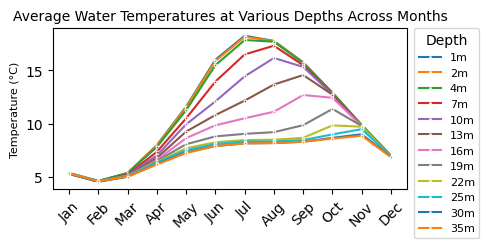

In [188]:
# Convert 'Date' column to datetime, if not already in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract the Month from the 'Date' column
df['Month'] = df['Date'].dt.month

# Drop rows where 'Month' is NaN (invalid date entries)
df = df.dropna(subset=['Month'])

# List of columns related to water temperature at different depths
temperature_columns = ['1m', '2m', '4m',
                       '7m', '10m',
                       '13m', '16m',
                       '19m', '22m', '25m', '30m', '35m']

# Map month numbers to month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Calculate average monthly temperature for each depth
monthly_avg = df.groupby(['Month'])[temperature_columns].mean().reset_index()

# Convert 'Month' to integers and replace month numbers with month names
monthly_avg['Month_Name'] = monthly_avg['Month'].astype(int).apply(lambda x: month_names[x-1])

# Create the plot
plt.figure(figsize=(5, 2.5))  # Slightly wider for better spacing

# Plot each temperature column with smaller markers
for col in temperature_columns:
    sns.lineplot(data=monthly_avg, x='Month_Name', y=col, marker='o', markersize=2, label=col)

plt.title('Average Water Temperatures at Various Depths Across Months', fontsize = 10)
plt.xlabel('')
plt.ylabel('Temperature (°C)', fontsize = 8)
plt.xticks(rotation=45)

# Move and shrink legend
plt.legend(
    title='Depth',
    fontsize = 4,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 8},      # Smaller font in legend
    markerscale=0.6        # Smaller markers in legend
)

plt.tight_layout()
plt.show()


The code computes and visualizes the correlation between water temperatures at various depths and environmental factors (Wind Speed and Pyranometer) using a heatmap. This allows for understanding how temperature at different depths relates to external variables.

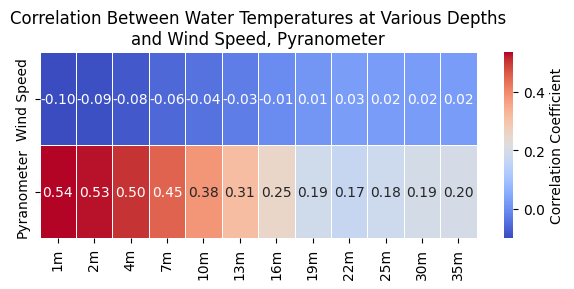

In [194]:
# Define columns
depth_columns = ['1m', '2m', '4m',
                       '7m', '10m',
                       '13m', '16m',
                       '19m', '22m', '25m', '30m', '35m']

target_columns = [ 'Wind Speed', 'Pyranometer']

# Initialize an empty DataFrame to store correlations
correlation_values = pd.DataFrame(index=target_columns, columns=depth_columns)

# Compute pairwise correlations
for target in target_columns:
    for depth in depth_columns:
        correlation_values.loc[target, depth] = df[target].corr(df[depth])

# Convert to float for heatmap
correlation_values = correlation_values.astype(float)

# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_values, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
           cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Between Water Temperatures at Various Depths\nand Wind Speed, Pyranometer', fontsize=12)
plt.tight_layout()
plt.show()


The code generates a line plot of average yearly water temperatures at various depths from the dataset. This helps to visualize the trend of water temperature changes across different depths over the years, making it easier to identify any significant patterns or anomalies.

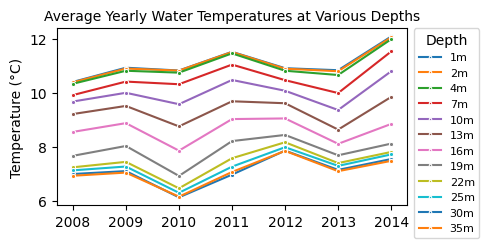

In [200]:
# Extract the Year from the 'Date' column
df['Year'] = df['Date'].dt.year

# List of columns related to water temperature at different depths
temperature_columns = ['1m', '2m', '4m',
                       '7m', '10m',
                       '13m', '16m',
                       '19m', '22m', '25m', '30m', '35m']

# Group by year and calculate average temperature for each depth
yearly_avg = df.groupby('Year')[temperature_columns].mean().reset_index()

# Exclude 2015
yearly_avg = yearly_avg[yearly_avg['Year'] != 2015]

# Create the plot
plt.figure(figsize=(5,2.5))  # Adjust width for legend space

# Plot each temperature column with smaller markers
for col in temperature_columns:
    sns.lineplot(data=yearly_avg, x='Year', y=col, marker='o', markersize=3, label=col)

plt.title('Average Yearly Water Temperatures at Various Depths', fontsize = 10)
plt.xlabel('')
plt.ylabel('Temperature (°C)')

# Move and shrink legend
plt.legend(
    title='Depth',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 8},
    markerscale=0.6
)

plt.tight_layout()
plt.show()


This code creates a boxplot to visualize the distribution of water temperatures at various depths, with a LOWESS (Locally Weighted Scatterplot Smoothing) line overlaid to highlight the smoothed trend of mean temperatures. The boxplot shows the temperature variation, including outliers, across the different depths, while the LOWESS line provides a clearer picture of the central tendency.

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\4018719454.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


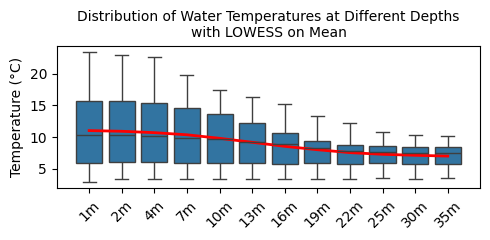

In [198]:
# Melt the dataframe for easier plotting
df_melted = df.melt(
    id_vars=['Date'],
    value_vars=temperature_columns,
    var_name='Depth',
    value_name='Temperature'
)

# Convert 'Depth' to ordered categorical type if needed for correct plotting
depth_order = sorted(temperature_columns, key=lambda x: float(x.replace('m', '')))
df_melted['Depth'] = pd.Categorical(df_melted['Depth'], categories=depth_order, ordered=True)

# Calculate mean temperature at each depth
mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()

# LOWESS smoothing
lowess_result = lowess(mean_temps['Temperature'], mean_temps['Depth'].apply(lambda x: float(x.replace('m',''))), frac=0.5)

# Plot boxplots
flier_props = dict(marker='o', color='red', markersize=2, linestyle='none', markerfacecolor='r', alpha=0.5)

plt.figure(figsize=(5, 2.5))
sns.boxplot(
    data=df_melted,
    x='Depth',
    y='Temperature',
    flierprops=flier_props
)

# Plot LOWESS line
x_vals = [str(int(x)) + 'm' if x.is_integer() else str(x) + 'm' for x in lowess_result[:, 0]]
y_vals = lowess_result[:, 1]
plt.plot(x_vals, y_vals, color='red', label='LOWESS (mean)', linewidth=2)

# Final plot adjustments
plt.title('Distribution of Water Temperatures at Different Depths\nwith LOWESS on Mean', fontsize=10)
plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The **Esthwaite Water Monitoring dataset** contains 689 records from **2008 to 2010**, capturing water temperatures at depths from **0.5m to 11.5m**, along with **air temperature**, **solar radiation (pyranometer)**, and **wind speed**. Exploratory data analysis revealed clear **seasonal variation** in surface temperatures, a **temperature decline with depth**, and **thermal stratification** across months. Correlation analysis showed **negative relationships between wind speed and surface temperatures**, and **positive correlations between solar radiation and shallow water temperatures**. Overall, the dataset effectively supports analysis of **lake thermal dynamics and environmental influences**.

In [202]:
df = pd.read_csv('Cleaned_Esthwaite_WaterMonitoring_Data.csv')
df.head()

Date      0.5m      1.5m      2.5m      3.5m      4.5m      5.5m  \
0  2008-01-01  5.933374  5.521357  5.502635  5.319235  5.173017  5.034083   
1  2008-01-02  5.595114  5.483757  5.482529  5.312171  5.145329  5.046400   
2  2008-02-05  5.541393  5.350121  5.438143  5.294957  5.131107  4.991500   
3  2008-02-06  5.395613  5.258888  5.336092  5.189021  5.053204  4.935638   
4  2008-02-07  5.436767  5.217071  5.298504  5.157750  5.026208  4.912250   

       6.5m      7.5m      8.5m      9.5m     10.5m     11.5m  \
0  4.913917  4.875765  4.715187  4.785791  4.849996  4.902709   
1  4.986414  4.974243  4.833743  4.812543  4.827300  4.816957   
2  4.887564  4.954107  4.817286  4.932214  5.052993  5.153650   
3  4.835296  4.897371  4.779708  4.875367  4.997762  5.082312   
4  4.820604  4.882329  4.757721  4.855004  4.971183  5.046604   

   Air Temperature  Pyranometer  Wind Speed  
0         7.270200    -5.820791    0.587826  
1         6.140543   -12.413286    1.188843  
2         5.728771    29.780221    2.323070  
3         5.281400    29.946008    2.264834  
4         7.285700     4.057280    2.101948

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             689 non-null    object 
 1   0.5m             689 non-null    float64
 2   1.5m             689 non-null    float64
 3   2.5m             689 non-null    float64
 4   3.5m             689 non-null    float64
 5   4.5m             689 non-null    float64
 6   5.5m             689 non-null    float64
 7   6.5m             689 non-null    float64
 8   7.5m             689 non-null    float64
 9   8.5m             689 non-null    float64
 10  9.5m             689 non-null    float64
 11  10.5m            689 non-null    float64
 12  11.5m            689 non-null    float64
 13  Air Temperature  689 non-null    float64
 14  Pyranometer      689 non-null    float64
 15  Wind Speed       689 non-null    float64
dtypes: float64(15), object(1)
memory usage: 86.2+ KB


In [206]:
df.shape

(689, 16)

In [208]:
df.describe()

0.5m        1.5m        2.5m        3.5m        4.5m        5.5m  \
count  689.000000  689.000000  689.000000  689.000000  689.000000  689.000000   
mean    11.224821   11.189590   11.127188   10.765843   10.287497    9.807984   
std      5.702767    5.647116    5.499921    5.179127    4.773905    4.382948   
min      0.895488    1.789358    0.816244    2.052742    2.138504    2.198104   
25%      5.931246    5.801704    5.886717    5.764846    5.658100    5.551079   
50%     11.394000   11.318875   11.333542   11.154583   11.029542   10.789542   
75%     16.488292   16.405375   16.335125   15.643250   14.792708   14.001750   
max     24.590583   24.381500   21.483542   19.476417   17.387458   16.851208   

             6.5m        7.5m        8.5m        9.5m       10.5m       11.5m  \
count  689.000000  689.000000  689.000000  689.000000  689.000000  689.000000   
mean     9.274470    8.828724    8.411271    8.247623    8.012945    7.763479   
std      3.969551    3.601773    3.326056    3.112660    2.857460    2.598835   
min      2.261592    2.315721    2.282000    2.352854    2.446896    2.495350   
25%      5.461500    5.463592    5.360221    5.455704    5.469887    5.528350   
50%      9.915642    9.027042    8.677150    8.663163    8.487367    8.334100   
75%     13.044958   11.889667   10.955375   10.730625   10.333583    9.705704   
max     15.279625   14.450958   13.800917   13.257583   13.008833   12.386333   

       Air Temperature  Pyranometer  Wind Speed  
count       689.000000   689.000000  689.000000  
mean        472.692662    96.253882    2.327419  
std        2748.189120    81.173344    1.344552  
min          -4.978767   -12.413286    0.000113  
25%           6.312283    27.733059    1.373268  
50%          10.920867    72.763813    2.108726  
75%          14.274625   146.543200    3.041145  
max       50003.709337   325.994721    9.887037

This monthly EDA plot reveals seasonal patterns in **Esthwaite water temperatures** from **2008–2010**, showing surface temperatures peaking mid-year and decreasing with depth. Deeper layers remain cooler and more stable, highlighting vertical thermal stratification and seasonal variation across the lake's water column.

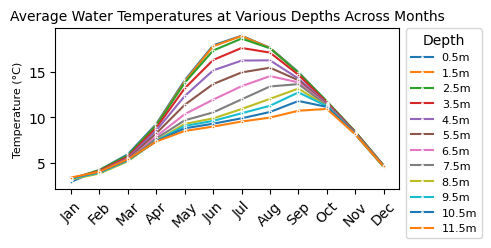

In [210]:
# Convert 'Date' column to datetime, if not already in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract the Month from the 'Date' column
df['Month'] = df['Date'].dt.month

# Drop rows where 'Month' is NaN (invalid date entries)
df = df.dropna(subset=['Month'])

# List of columns related to water temperature at different depths
temperature_columns = ['0.5m', '1.5m','2.5m','3.5m','4.5m','5.5m','6.5m','7.5m','8.5m','9.5m','10.5m','11.5m']

# Map month numbers to month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Calculate average monthly temperature for each depth
monthly_avg = df.groupby(['Month'])[temperature_columns].mean().reset_index()

# Convert 'Month' to integers and replace month numbers with month names
monthly_avg['Month_Name'] = monthly_avg['Month'].astype(int).apply(lambda x: month_names[x-1])

# Create the plot
plt.figure(figsize=(5, 2.5))  # Slightly wider for better spacing

# Plot each temperature column with smaller markers
for col in temperature_columns:
    sns.lineplot(data=monthly_avg, x='Month_Name', y=col, marker='o', markersize=2, label=col)

plt.title('Average Water Temperatures at Various Depths Across Months', fontsize = 10)
plt.xlabel('')
plt.ylabel('Temperature (°C)', fontsize = 8)
plt.xticks(rotation=45)

# Move and shrink legend
plt.legend(
    title='Depth',
    fontsize = 4,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    prop={'size': 8},      # Smaller font in legend
    markerscale=0.6        # Smaller markers in legend
)

plt.tight_layout()
plt.show()


This correlation heatmap highlights how **surface temperatures** in Esthwaite are **positively correlated** with **pyranometer readings** (solar radiation), especially near the top layers, while **wind speed** shows **weaker or slightly negative correlations**, indicating limited influence on deeper thermal profiles.

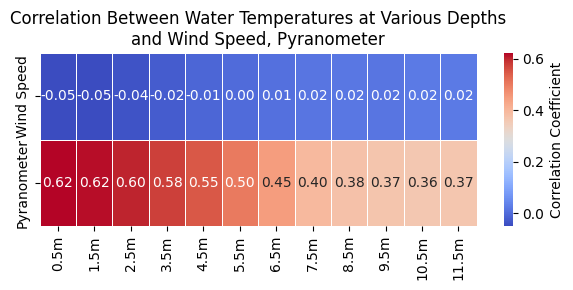

In [214]:
# Define columns
depth_columns = ['0.5m', '1.5m','2.5m','3.5m','4.5m','5.5m','6.5m','7.5m','8.5m','9.5m','10.5m','11.5m']

target_columns = [ 'Wind Speed', 'Pyranometer']

# Initialize an empty DataFrame to store correlations
correlation_values = pd.DataFrame(index=target_columns, columns=depth_columns)

# Compute pairwise correlations
for target in target_columns:
    for depth in depth_columns:
        correlation_values.loc[target, depth] = df[target].corr(df[depth])

# Convert to float for heatmap
correlation_values = correlation_values.astype(float)

# Plot the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_values, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
           cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Between Water Temperatures at Various Depths\nand Wind Speed, Pyranometer', fontsize=12)
plt.tight_layout()
plt.show()


This plot reveals that **surface water temperatures** in Esthwaite are generally **higher and more variable**, while **deeper layers** show **lower, more stable temperatures**. The red **LOWESS curve** illustrates a **gradual decline in average temperature with depth**, confirming expected thermal stratification patterns in freshwater lakes.

C:\Users\HP\AppData\Local\Temp\ipykernel_33816\4018719454.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()
C:\Users\HP\anaconda3\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


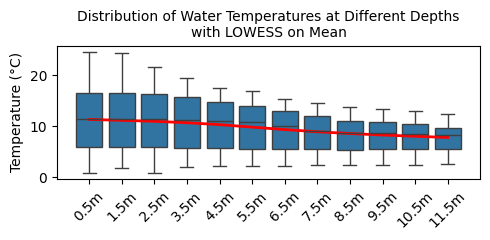

In [218]:
# Melt the dataframe for easier plotting
df_melted = df.melt(
    id_vars=['Date'],
    value_vars=temperature_columns,
    var_name='Depth',
    value_name='Temperature'
)

# Convert 'Depth' to ordered categorical type if needed for correct plotting
depth_order = sorted(temperature_columns, key=lambda x: float(x.replace('m', '')))
df_melted['Depth'] = pd.Categorical(df_melted['Depth'], categories=depth_order, ordered=True)

# Calculate mean temperature at each depth
mean_temps = df_melted.groupby('Depth')['Temperature'].mean().reset_index()

# LOWESS smoothing
lowess_result = lowess(mean_temps['Temperature'], mean_temps['Depth'].apply(lambda x: float(x.replace('m',''))), frac=0.5)

# Plot boxplots
flier_props = dict(marker='o', color='red', markersize=2, linestyle='none', markerfacecolor='r', alpha=0.5)

plt.figure(figsize=(5, 2.5))
sns.boxplot(
    data=df_melted,
    x='Depth',
    y='Temperature',
    flierprops=flier_props
)

# Plot LOWESS line
x_vals = [str(int(x)) + 'm' if x.is_integer() else str(x) + 'm' for x in lowess_result[:, 0]]
y_vals = lowess_result[:, 1]
plt.plot(x_vals, y_vals, color='red', label='LOWESS (mean)', linewidth=2)

# Final plot adjustments
plt.title('Distribution of Water Temperatures at Different Depths\nwith LOWESS on Mean', fontsize=10)
plt.xlabel('')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
